# Problem Set 3, due October 2 at 11:59pm.

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
import sklearn
import time

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function (other than sqrt) to compute RMSE.



In [3]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((2,2,3),(0,2,6)))
2.08
"""
def compute_rmse(predictions, yvalues):
    # Compute the number of observations
    n = len(predictions)
    
    # Initialize squared difference sum
    sqdiff = 0

    # Summation loop
    for i in range(0, n):
        sqdiff += (predictions[i] - yvalues[i]) ** 2

    # Calculate the square root
    rmse = np.sqrt(sqdiff / n)
        
    # Note: If we want to match the example output, we should
    # calculate the square root and truncate the digit up to 2 decimals 
    # We include the following line as an alternative for matching the 
    # number of decimals from the examples
    
    #rmse = np.round(np.sqrt(sqdiff / n), decimals = 2)
    
    # Return rmse value
    return rmse
    

In [4]:
# Testing the function
print(compute_rmse((2,2,3),(0,2,6)))

2.08166599947


### 1.2 Divide your data into training and testing datasets

Randomly select 80% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 20% in a testing dataset (call this "bdata_test")


In [5]:
# leave the following line untouched, it will help ensure that your "random"
# split is the same "random" split used by the rest of the class

# Random seed
np.random.seed(seed = 13579)

# First approach: Different from the one shown in lab 4, we include it as 
# an alternative (more efficient method) using sample function (pandas)
# Initialize a Pandas DataFrame with Boston data
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]

# Add the MEDV variable
boston['MEDV'] = bdata.target

# Check dimension and head
r, c = boston.shape
print("Total number of observations (full set):", r)

# 80% of the data goes to the training dataset
bdata_train = boston.sample(frac = 0.8,
                            random_state = np.random.seed(seed = 13579))
bdata_train.sort_index(inplace = True)
rtr, ctr = bdata_train.shape
print("Total number of observations (training set):", rtr)

# Remaining 20% of the data goes to the testing dataset
bdata_test = boston.loc[~boston.index.isin(bdata_train.index)]
bdata_test.sort_index(inplace = True)
rtest, ctest = bdata_test.shape
print("Total number of observations (testing set):", rtest)

# Display both sets (head)
display(bdata_train.head())
display(bdata_test.head())

Total number of observations (full set): 506
Total number of observations (training set): 405
Total number of observations (testing set): 101


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9
10,0.22489,12.5,7.87,0.0,0.524,6.377,94.3,6.3467,5.0,311.0,15.2,392.52,20.45,15.0
11,0.11747,12.5,7.87,0.0,0.524,6.009,82.9,6.2267,5.0,311.0,15.2,396.90,13.27,18.9
18,0.80271,0.0,8.14,0.0,0.538,5.456,36.6,3.7965,4.0,307.0,21.0,288.99,11.69,20.2
20,1.25179,0.0,8.14,0.0,0.538,5.570,98.1,3.7979,4.0,307.0,21.0,376.57,21.02,13.6


In [6]:
# Lab 4 version: split data using random.choice function (numpy)
# Note that the approximation is different in this case, where
# the training set contains 404 entries instead of 405 as in the 
# previous method

# Random seed 
np.random.seed(seed = 13579)

# Split the data: 80% for training set, remaining 20% testing set
train_idx = np.random.choice(range(len(boston)), int(len(boston) * .8), 
                             replace=False)
test_idx = list(set(range(len(boston))) - set(list(train_idx)))

# Training set and MEDV values
train_v_names = list(set(boston.columns.tolist()) - set(['MEDV']))
train_x = boston.loc[train_idx, train_v_names]
train_y = boston.loc[train_idx, 'MEDV']

# MEDV vectors
test_x = boston.loc[test_idx, train_v_names]
test_y = boston.loc[test_idx, 'MEDV']

# Check all shapes 
trrx, trcx = train_x.shape
tsrx, tscx = test_x.shape
print("Total number of variables:", trcx)
print("Total number of observations (training set [80%]):", trrx)
print("Total number of observations (testing set [20%]):", tsrx)

# Checking MEDV vectors shape
print("\nMEDV vectors (Y var) shape:")
print("Training set:", train_y.shape)
print("Training set:", test_y.shape)

# Sort the DFs and vectors for visualization purposes
# we show the target values separated from the features
print("\nTraining set head (without MEDV)")
train_x.sort_index(inplace = True)
display(train_x.head())

train_y.sort_index(inplace = True)
print("Training set target values")
display(train_y.head())

print("Testing set head (without MEDV)")
test_x.sort_index(inplace = True)
display(test_x.head())

test_y.sort_index(inplace = True)
print("Testing set target values")
display(test_y.head())

# Reference using given names: for completeness we merge 
# them with the target values as a column
bdata_test = pd.concat([test_x, test_y], axis = 1)
bdata_train = pd.concat([train_x, train_y], axis = 1)

Total number of variables: 13
Total number of observations (training set [80%]): 404
Total number of observations (testing set [20%]): 102

MEDV vectors (Y var) shape:
Training set: (404,)
Training set: (102,)

Training set head (without MEDV)


,TAX,NOX,DIS,AGE,PTRATIO,B,CRIM,INDUS,LSTAT,RM,ZN,RAD,CHAS
0,296.0,0.538,4.0900,65.2,15.3,396.90,0.00632,2.31,4.98,6.575,18.0,1.0,0.0
1,242.0,0.469,4.9671,78.9,17.8,396.90,0.02731,7.07,9.14,6.421,0.0,2.0,0.0
2,242.0,0.469,4.9671,61.1,17.8,392.83,0.02729,7.07,4.03,7.185,0.0,2.0,0.0
3,222.0,0.458,6.0622,45.8,18.7,394.63,0.03237,2.18,2.94,6.998,0.0,3.0,0.0
4,222.0,0.458,6.0622,54.2,18.7,396.90,0.06905,2.18,5.33,7.147,0.0,3.0,0.0


Training set target values


0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

Testing set head (without MEDV)


,TAX,NOX,DIS,AGE,PTRATIO,B,CRIM,INDUS,LSTAT,RM,ZN,RAD,CHAS
9,311.0,0.524,6.5921,85.9,15.2,386.71,0.17004,7.87,17.10,6.004,12.5,5.0,0.0
10,311.0,0.524,6.3467,94.3,15.2,392.52,0.22489,7.87,20.45,6.377,12.5,5.0,0.0
11,311.0,0.524,6.2267,82.9,15.2,396.90,0.11747,7.87,13.27,6.009,12.5,5.0,0.0
18,307.0,0.538,3.7965,36.6,21.0,288.99,0.80271,8.14,11.69,5.456,0.0,4.0,0.0
20,307.0,0.538,3.7979,98.1,21.0,376.57,1.25179,8.14,21.02,5.570,0.0,4.0,0.0


Testing set target values


9     18.9
10    15.0
11    18.9
18    20.2
20    13.6
Name: MEDV, dtype: float64

### 1.3 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Specifically, do the following:
1. Compute the RMSE of the training set.
2. Now compute the RMSE on the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?

Full Algorithm Time: 0.00049s
Predicted values Time: 0.00000s
RMSE training set: 9.20728120783
RMSE testing set: 9.11139618372
RMSE difference (training - testing): 0.095885024101


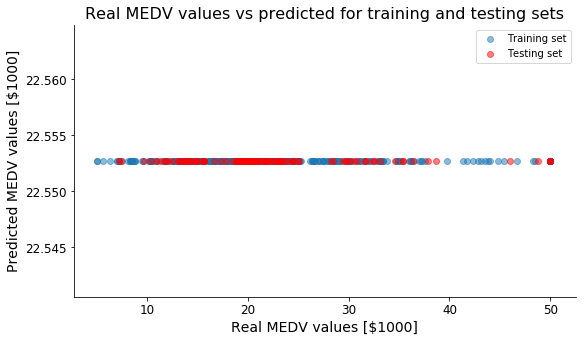

In [7]:
"""
Function
--------
meanModel

Given two arrays, the training and testing target variable values,
compute the Roote Mean Squared Error and predictions for both sets.
In addition, overall running time and specific computations for getting
the predictions for the testing data are performed.

Parameters
----------
train_y : array
    Array of numerical values corresponding to the target values of the training set

test_y : array
    Array of numerical values corresponding to the target values of the testing set

Returns
-------
yhat_vector_test : array
    Array of predictions for the testing set

RMSETest : float
    Root Mean Squared Error for the testing set
    
yhat_vector_training : array
    Array of predictions for the training set

RMSETraining : float
    Root Mean Squared Error for the training set

runningTime : float
    Total running time of the function

runningTimeTestVal : float
    Running time for computing the predictions for the testing set

Example
-------
>>> meanModel(train_y, test_y)
[yhat_vector_test, RMSETest], 
[yhat_vector_training,RMSETraining], 
runningTime, runningTimeTestVal
=
[[23, 31.2, 55.3, ...], 7.56], 
[[22.4, 44.5, 12.1, ...], 7.33],
0.12, 0.04
"""
# Declaring the function
def meanModel(train_y, test_y):    
    # Running time measure
    t_start = time.time()
    
    ## Step 1: Calculate the mean of the MEDV values
    # Compute the mean MEDV from training set
    yhat = np.mean(train_y)

    # Compute the first step running time
    t_specific_end = time.time()
    t01 = t_specific_end - t_start

    ## Step 2: RMSE of the Training set
    # Create the vector for the predictor 
    yhat_vector_training = np.repeat(yhat, len(train_y))

    # Create a numeric vector from MEDV in training set
    ytraining = train_y.values

    # Compute the RMSE for the training set calling the compute_rmse function
    RMSETraining = compute_rmse(yhat_vector_training, ytraining)
    
    ## Step 3: RMSE of the test data set
    # Specific calculation running time: predicted values data test
    t_specific_start = time.time()

    # Create the testing set predictor vector
    yhat_vector_test = np.repeat(yhat, len(test_y))

    # Compute the total running time for the test data
    t_specific_end = time.time()
    runningTimeTestVal = t_specific_end - t_specific_start
    
    # Create a numeric vector from MEDV in training set
    ytest = test_y.values

    # Compute the RMSE for the training set
    RMSETest = compute_rmse(yhat_vector_test, ytest)

    ## Step 4: RMSEs difference
    RMSEDiff = RMSETraining - RMSETest
    
    # Compute the total running time
    t_end = time.time()
    runningTime = t_end - t_start
       
    # Return results and total running time
    return([yhat_vector_test, RMSETest], 
           [yhat_vector_training,RMSETraining], 
           runningTime, runningTimeTestVal)

# Call the function, get results and print relevant information 
[TestResults, TrainingResults, FRunningTime, TestRunningTime] = meanModel(train_y, test_y)    
print("Full Algorithm Time: {:.5f}s".format(FRunningTime))   
print("Predicted values Time: {:.5f}s".format(TestRunningTime))
print("RMSE training set:", TrainingResults[1])
print("RMSE testing set:", TestResults[1])
print("RMSE difference (training - testing):", TrainingResults[1] - TestResults[1])
    
    
# Scatter plot function    
def ScatterPlot(TrainingResults, TestResults, ytraining, ytest):    
    # Scatter plot real vs predicted values for MEDV variable: training and testing sets
    # Figure size
    plt.figure(figsize = (9, 5)) 

    # Font sizes
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['figure.titlesize'] = 12

    # axes
    ax = plt.subplot(111)                    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 

    # Title and labels
    plt.title(r'Real MEDV values vs predicted for training and testing sets')
    plt.xlabel(r'Real MEDV values [$1000]')
    plt.ylabel(r'Predicted MEDV values [$1000]')

    # Plot
    ax.scatter(ytraining, TrainingResults[0], alpha = 0.5, 
               label = 'Training set')
    ax.scatter(ytest, TestResults[0], alpha = 0.5, label = 'Testing set',
               color = "red")
    plt.legend()
    
# Plot: Call the ScatterPlot function
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

In [8]:
# Timeit version
%timeit meanModel(train_y, test_y)

444 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?

Based on our previous results, we can see that the Root Mean squared errors obtained are (rounded to 2 decimals):
  - $RMSE_{training} = 9.21$ 
  - $RMSE_{testing} = 9.11$
  
Thus, both values are very similar, with a slight difference of $0.1$ units. This result was expected since a basic assumption for developing statistic studies over a population consists of the fact that the collected data was selected completely at random (a random experiment), meaning that both groups, training, and testing, should be statistically identical without having a significant baseline difference, pattern that is expected if the experiment was conducted in a way such that the random sampling was correctly performed and implemented. 

Therefore, we can clearly see in this case that, as expected, both groups performance with our first predictor model are almost identical, meaning that their characteristics are very homogeneous (similar), allowing us to conduct a series of experiments/models under the assumption of a full random experiment. However, further analysis must be done in order to conclude that no significant statistical baseline difference exists, such as a t-test (like in previous problem sets).
  
### How long does it take to compute the predicted values for the test data?

The entire algorithm takes only $0.0005 [s]$  as reported in the previous results. This is due to the fact that we are simply calculating a mean value from a numerical vector: a very simple and fast computation.

In the case of the time involved in the specific calculation of the predicted values for the test data, we can see that the resulting time tends to $0 [s]$, meaning that it is almost an instant calculation. We expected a value close to zero since the implemented algorithm is very simple: the testing data prediction values consists of a series of repetitions of the mean value $\hat{y}_{training} = \sum_{i \in Training} \dfrac{y_i}{n_{training}}$, a task that is efficiently implemented using the numpy arrays.

In addition, using the %timeit function, we obtain the following result for the total running time of the algorithm:
 - Estimated time: $444 µs ± 21.1 µs$ per loop (mean $±$ std. dev. of $7$ runs, $1000$ loops each)

### Scatter Plot Observations
Looking at the plot, we can easily notice that our model performance is very poor since the difference between the predicted and the real values are significant, leading to a high error level in terms of the predictive accuracy of the current model. Therefore, we can discard the current model for the rest of the analysis, due to its poor performance.

### Note: Time estimations will vary from run to run depending on the computer and the number of parallel tasks in execution. 

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm][1] distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).
[1]: https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm

In [9]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print(distance((3,4),(6,8),2))
5
"""
def distance(x1, x2, L):
    
    # Number of entries
    n = len(x1)
    
    # Initialize the summation/dif var
    pdif = 0
    
    # Summation loop
    for i in range(0,n):
        pdif += (abs((x1[i] - x2[i]))) ** L
    
    # L norm distance computation
    dist = pdif ** (1 / L)
    
    # Return distance value
    return dist

In [10]:
# Testing the function
print(distance((3,4),(6,8),2))
print(distance([3,4],[6,8],2))

5.0
5.0


### 2.2 Basic Nearest Neighbor algorithm

Your next task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Make sure to do the following
1. Fill in the function specification below
2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. 
5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

Testing instance
Time taken: 0.13 seconds
RMSE testing set: 7.70617272316

Training instance
Time taken: 0.52 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.70617272316


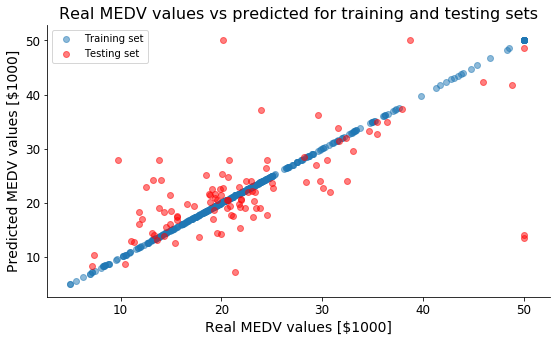

In [11]:
"""
Function
--------
nneighbor

Given a training and a testing sets observations x and target variable y, and a value for L (norm), 
return the Root mean squared error and the predictor yhat for the testing set

Parameters
----------
train_x, test_x : DataFrames
    DataFrames containing all the values corresponding to the features (x) of the N observations 

train_y, test_y : DataFrames (Series)
    DataFrames containing all the values corresponding to the target variable (y) of the N observations 

L: int
    Value of L to use in computing distances

Returns
-------
yhat_test: float array
    The predictor vector for the testing instance

rmse : float
    The Root Mean Squared Error associated with the testing data

Example  
-------
>>> train_x = ; train_x = ;
>>> test_x = ; test_y = ;
>>> [RMSE, yhat] = nneighbor(train_x, train_y, test_x, test_y, 2)
>>> print(RMSE, yhat)
7.56, [54.3, 54.6, 24.5, 13.4, ...]
"""
import time
def nneighbor(train_x, train_y, test_x, test_y, L):
    # Function starting time
    start_time = time.time()
    
    # Step 1: Compute the distance between training set and testing set observations
    # Number of Observations
    ntest = len(test_x)
    ntrain = len(train_x)
    
    # Min Distance and index vectors
    MinDist = np.repeat(1e10, ntest)
    MinIndex = np.repeat(0, ntest)
    
    # Predictor vector
    yhat_test = np.repeat(0.0, ntest)
         
    # Transform DF values to numerical inputs
    train_input = train_x.values
    test_input = test_x.values
    
    # Distance loop: Test and Training
    for i in range(0, ntest):
        for j in range(0, ntrain):
            # Calculate the distance 
            Ldist = distance(train_input[j], test_input[i], L)
            
            # If better value (smaller), update current solution
            if Ldist < MinDist[i]:
                MinDist[i] = Ldist
                MinIndex[i] = j
                yhat_test[i] = train_y.values[j]
               
    # Step 2: Compute RMSE value
    rmse = compute_rmse(yhat_test, np.array(test_y))
    
    # Compute running time
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    
    # Return Root mean squared error and predictor 
    return (yhat_test, rmse) 


## Main code
# Step 0: L value and relevant features
L = 2
ftrain_x = train_x[['CRIM', 'RM']]
ftest_x = test_x[['CRIM', 'RM']]

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ftrain_x, train_y, ftest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ftrain_x, train_y, ftrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

In [12]:
# Running time estimation using %timeit
%timeit nneighbor(ftrain_x, train_y, ftest_x, test_y, L)

Time taken: 0.13 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.15 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.13 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.13 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds


## Observations 
 ### RMSEs
 
 Based on our previous results, we can see that the Root Mean squared errors obtained are (rounded to 2 decimals):
  - $RMSE_{training} = 0.00$ 
  - $RMSE_{testing} = 7.71$
  
The explanation behind the null value for the $RMSE_{training}$ consists of the fact that in the Nearest Neighbor algorithm we are using the entire training set for "fitting the model", but we know that there is no real training since we are fitting the model for the testing set based on the minimum distance (closest neighbor) between each observation inside the testing set and the ones inside the training set. Therefore, if we apply the "model" to the training set, we will end up with their exactly original value for the target value $MEDV$ since each observation is clearly its own Nearest Neighbor. Therefore, there is no Root Mean Squared Error associated with the training set.

On the other hand, we can easily notice that the $RMSE_{testing}$ value has decreased in comparison to the previous (bad) predictive model, from $9.11$ to $7.71$. Thus, the current Nearest Neighbor model is more accurate (in terms of the predictions) than the meanModel.
  
  
 ### Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
 
 Looking at the output from the algorithm, the estimation of the total time needed to predict the Nearest Neighbor for all the values in the test data set is equal to $0.13$ seconds. Clearly, this value may change depending on the computer and the amount of multiple tasks running in parallel.
 
 Using the %timeit function (previous code chunk), we obtain the following result:
 - Estimated time: $121 ms ± 2.51 ms$ per loop (mean $±$ std. dev. of $7$ runs, $10$ loops each)
 
 
 ### How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?
 
 Based on the obtained results, we can summarize the outputs from both models in the following table:
 
 |                  | # Features | Features | L-value | RMSE (test) | Running Time [s] |
|------------------|:----------:|:--------:|:-------:|:-----------:|:----------------:|
| Mean Model       |      -     | -        |    -    |     9.11    |       0.001      |
| Nearest Neighbor |      2     | CRIM, RM |    2    |     7.71    |       0.130      |

As we already discussed at the beginning of this seciton, the $RMSE_{testing}$ value has decreased (improved) with the Nearest Neighbor algorithm, decreasing it in $1.4$ units. The explanation behind this is clear: the new model (NN) has a better predictive accuracy in comparison to the original baseline model due to the fact that it processes and takes into account each testing entry as an individual observation instead of performing a loose approximation using the mean from all the training set observations as the main (and only) predictor.

However, we can see that, since we are performing a series of calculations such as computing the distances between arrays and computing the $RMSE$ values, the total runtime of the Nearest Neighbor algorithm is two levels of magnitude larger than the time spent on the Mean Model (in powers of ten). Therefore, in general we need to take into account the trade-off between the accuracy and precision of the model with the total runtime involved in solving/fitting it, since a very good model may inccur in higher costs (time, money, hardware resources, etc.) than a not-so-good model, and thus, maybe the researchers will need to avoid using it.

In our particular case however, since the total runtime of our Nearest Neighbor algorithm is almost impercetible (about a tenth of a second), we can clearly select it as our main model. Here, the trade-off loose its "validity" due to the fact that both total running times are insignificant/negligible, and hence the more complex model (NN) is suitable for our particular application/study.

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [13]:
"""
Function
--------
normalize

Given an array (any dimension) return a normalized array by substracting 
the mean and dividing by the standard deviation of each component.

Parameters
----------
raw_data : float array (any dimension)
    Array containing numerical data 

Returns
-------
normalized_data: float array (any dimension)
    Array containing the normalized values from the original data

Example 
-------
>>> print(normalize([10,5,3,2])
array([ 1.62221421,  0.        , -0.64888568, -0.97332853])
"""

def normalize(raw_data):
    # Compute the mean and std of the array
    mean = np.mean(raw_data)
    std = np.std(raw_data)
    
    # Normalize
    normalized_data = (raw_data - mean) / std
    
    # Return normalized array
    return normalized_data

# Testing the function
test = np.array([10, 5, 2, 3])
normalized_test = normalize(test)
display(normalized_test)

array([ 1.62221421,  0.        , -0.97332853, -0.64888568])

Testing instance
Time taken: 0.12 seconds
RMSE testing set: 7.86132254502

Training instance
Time taken: 0.47 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.86132254502


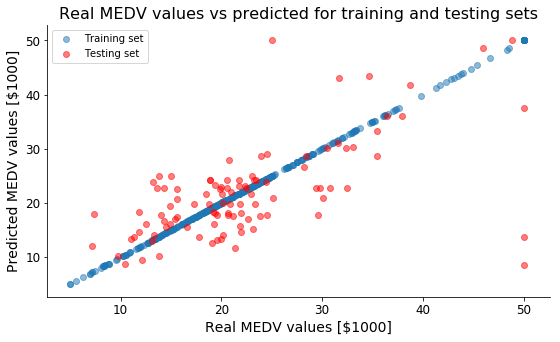

In [14]:
# Run Nearest Neighbor with normalized data
# Step 0: L value and normalize data
L = 2
ntrain_x = normalize(train_x[['CRIM', 'RM']])
ntest_x = normalize(test_x[['CRIM', 'RM']])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

In [15]:
# Extra test for visualizing purposes
normalize(test_x).head()

,TAX,NOX,DIS,AGE,PTRATIO,B,CRIM,INDUS,LSTAT,RM,ZN,RAD,CHAS
9,-0.615171,-0.405984,1.636166,0.499689,-1.417654,0.282902,-0.355775,-0.545614,0.530413,-0.423516,0.061960,-0.592345,-0.32969
10,-0.615171,-0.405984,1.507650,0.825787,-1.417654,0.368407,-0.350002,-0.545614,0.998267,0.167964,0.061960,-0.592345,-0.32969
11,-0.615171,-0.405984,1.444806,0.383226,-1.417654,0.432866,-0.361308,-0.545614,-0.004477,-0.415588,0.061960,-0.592345,-0.32969
18,-0.638139,-0.289189,0.172108,-1.414193,1.152631,-1.155220,-0.289185,-0.506439,-0.225137,-1.292501,-0.477285,-0.702198,-0.32969
20,-0.638139,-0.289189,0.172841,0.973307,1.152631,0.133674,-0.241919,-0.506439,1.077872,-1.111727,-0.477285,-0.702198,-0.32969


In [16]:
# Running time test using %timeit
%timeit nneighbor(ntrain_x, train_y, ntest_x, test_y, L)

Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.14 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds


In [17]:
# Running time for normalization
%timeit ntrain_x = normalize(train_x[['CRIM', 'RM']])
%timeit ntest_x = normalize(test_x[['CRIM', 'RM']])

1.19 ms ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.14 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Observations
### Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

Based on the previous results, we can summarize the models statistics in the following table: 

|                             | # Features | Features | L-value | RMSE (test) | Running Time [s] |
|-----------------------------|:----------:|:--------:|:-------:|:-----------:|:----------------:|
| Mean Model                  |      -     | -        |    -    |     9.11    |       0.001      |
| Nearest Neighbor            |      2     | CRIM, RM |    2    |     7.71    |       0.130      |
| Normalized Nearest Neighbor |      2     | CRIM, RM |    2    |     7.86    |       0.120      |

Looking at the table, we can notice that the $RMSE_{testing}$ value in the current model (Normalized Nearest Neighbor) is larger than the one obtained with the non-normalized version. This is a counter-intuitive result since the normalization of the features should help the model to not commit classification/prediction errors due to the range/scale/unit of the features involved. This happens because in algorithms like the Nearest Neighbor we are measuring a set of distances between pairs of samples and thus, these distances will be influenced by the measurement units involved. This is the main reason why we should normalize our features before apply any algorithm where the distance between samples/entries play a vital role for prediction. 

However, we can see that in our particular implementation/problem the normalization of the included features does not improve the model $RMSE_{testing}$ value, leading to a less accurate predictive model. On the other hand, we can see that the difference between both $RMSE$ values is not extremely large (only $0.15$ units) so we cannot conclude that the normalization would not be a good practice in our model when including different features. Further analysis and experimentation should be developed in order to formally contrast both models.

As with the non-normalized model, the current implementation has decreased the $RMSE$ value in comparison to the Mean Model by $1.25$ units.

Regarding the running time of the algorithms, since we are performing the normalization of the data/features before calling the model, the running time estimation is exactly as the one obtained for the non-normalized model ($0.120$ vs $0.130 [s]$). For completeness, we can calculate the estimated time needed for performing the normalization operation using our normalize() function:
 - Training set normalization estimated running time: $1.19 ms ± 9.64 µs$ per loop (mean $±$ std. dev. of $7$ runs, $1000$ loops each)
 - Testing set normalization estimated running time: $1.14 ms ± 11.4 µs$ per loop (mean $±$ std. dev. of $7$ runs, $1000$ loops each)
 
From the results above, we can easily check that both estimated running times are almost insignificant in comparison to the main algorithm running time, and thus, we can say that both versions (normalized and non-normalized) of our Nearest Neighbor algorithm tend to incur in the same estimated running time. Again, since all the running times are insignificant in terms of magnitude, we will prefer the Nearest Neighbor models instead of the Mean Model with poor predictive performance.

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

*NOTE:* For this and all subsequent questions, you should use normalized features

Testing instance
Time taken: 0.12 seconds
RMSE testing set: 10.895578344

Training instance
Time taken: 0.47 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -10.895578344


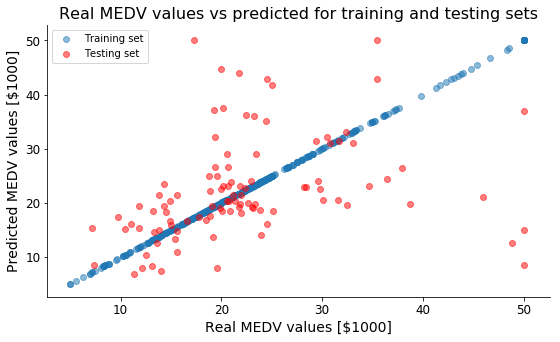

In [18]:
# Model 1: 2 different features
# Step 0: L value and normalize data
L = 2
ntrain_x = normalize(train_x[['DIS', 'AGE']])
ntest_x = normalize(test_x[['DIS', 'AGE']])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

Testing instance
Time taken: 0.24 seconds
RMSE testing set: 7.41863049568

Training instance
Time taken: 0.97 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.41863049568


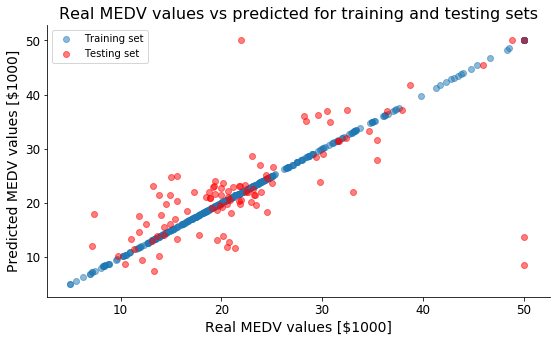

In [19]:
# Model 2: More than 4 features
# Step 0: L value and normalize data
L = 2
features = ['CRIM', 'RM', 'DIS', 'TAX', 'ZN', 'INDUS']
ntrain_x = normalize(train_x[features])
ntest_x = normalize(test_x[features])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

Testing instance
Time taken: 0.14 seconds
RMSE testing set: 7.83325615315

Training instance
Time taken: 0.47 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.83325615315


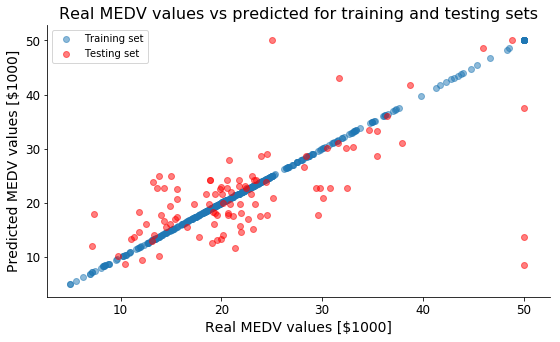

In [20]:
# Model 3: Diferent L value
# Step 0: L value and normalize data
L = 3
ntrain_x = normalize(train_x[['CRIM', 'RM']])
ntest_x = normalize(test_x[['CRIM', 'RM']])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

Testing instance
Time taken: 0.12 seconds
RMSE testing set: 7.77162384929

Training instance
Time taken: 0.47 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.77162384929


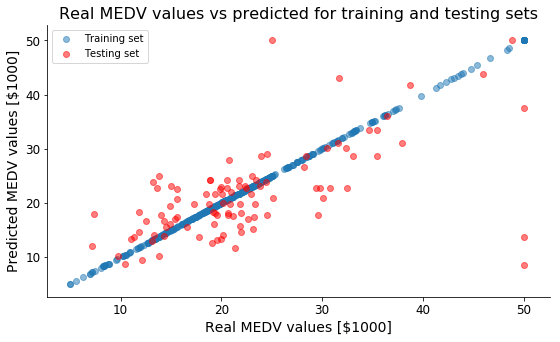

In [21]:
# Model 4: Diferent L value 2nd
# Step 0: L value and normalize data
L = 10
ntrain_x = normalize(train_x[['CRIM', 'RM']])
ntest_x = normalize(test_x[['CRIM', 'RM']])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

Testing instance
Time taken: 0.25 seconds
RMSE testing set: 7.58125267729

Training instance
Time taken: 0.96 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.58125267729


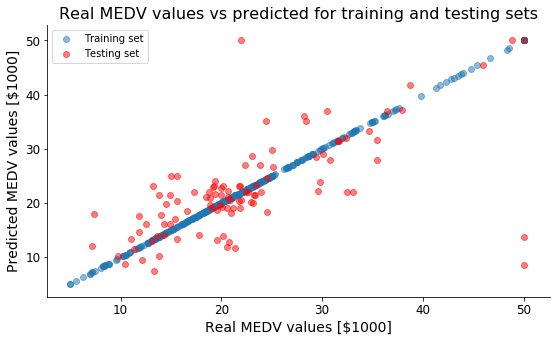

In [22]:
# Model 5: Combination 1
# Step 0: L value and normalize data
L = 10
features = ['CRIM', 'RM', 'DIS', 'TAX', 'ZN', 'INDUS']
ntrain_x = normalize(train_x[features])
ntest_x = normalize(test_x[features])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

Testing instance
Time taken: 0.29 seconds
RMSE testing set: 7.50591923281

Training instance
Time taken: 1.10 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.50591923281


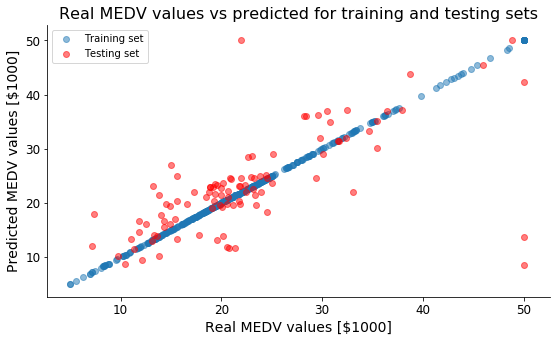

In [23]:
# Model 6: Combination 2
# Step 0: L value and normalize data
L = 1
features = ['CRIM', 'RM', 'DIS', 'TAX', 'ZN', 'INDUS', 'PTRATIO', 'RAD']
ntrain_x = normalize(train_x[features])
ntest_x = normalize(test_x[features])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

Testing instance
Time taken: 0.31 seconds
RMSE testing set: 7.65711894829

Training instance
Time taken: 1.23 seconds
RMSE training set: 0.0

RMSE difference (training - testing): -7.65711894829


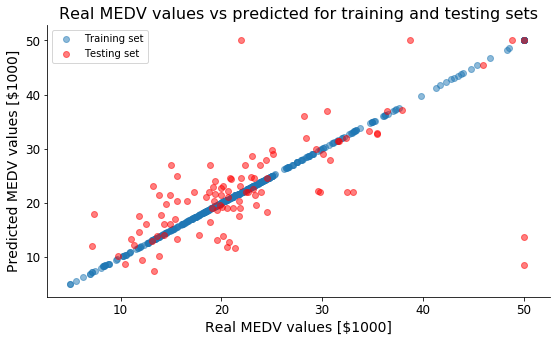

In [24]:
# Model 7: Combination 3
# Step 0: L value and normalize data
L = 50
features = ['CRIM', 'RM', 'DIS', 'TAX', 'ZN', 'INDUS', 'PTRATIO', 'RAD']
ntrain_x = normalize(train_x[features])
ntest_x = normalize(test_x[features])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
print("RMSE testing set:", TestResults[1])

# Step 2: RMSE for training data
print ("\nTraining instance")
TrainingResults = nneighbor(ntrain_x, train_y, ntrain_x, train_y, L)
print("RMSE training set:", TrainingResults[1])

# Step 3: Print Comparison
print("\nRMSE difference (training - testing):", 
      TrainingResults[1] - TestResults[1])

# Step 4: Scatter plot
ytraining = train_y.values
ytest = test_y.values
ScatterPlot(TrainingResults, TestResults, ytraining, ytest)

## Observations
### What combination of features and distance function provide the lowest RMSE? Do your decisions affect the running time of the algorithm?

Based on the previous outputs, we obtain the following summary table:

|         | # Features |                Features                | L-value |  RMSE (test) | Running Time [s] |
|---------|:----------:|:--------------------------------------:|:-------:|:------------:|:----------------:|
| Model 1 |      2     | DIS,AGE                                |    2    | 10.90        |       0.12       |
| Model 2 |      6     | CRIM,RM,DIS,TAX,ZN,INDUS               |    2    |  7.42        |       0.24       |
| Model 3 |      2     | CRIM,RM                                |    3    |  7.83        |       0.14       |
| Model 4 |      2     | CRIM,RM                                |    10   |  7.77        |       0.12       |
| Model 5 |      6     | CRIM,RM,DIS,TAX,ZN,INDUS               |    10   |  7.58        |       0.25       |
| Model 6 |      8     | CRIM,RM,DIS,TAX,ZN,INDUS,PTRATIO,RAD   |    1    |  7.51        |       0.29       |
| Model 7 |      8     | CRIM,RM,DIS,TAX,ZN,INDUS,PTRATIO,RAD   |    50   |  7.66        |       0.31       |

Looking at the results presented in the table, we can see that the best model tested in terms of $RMSE_{testing}$ consists of the Model number $2$, where we included $6$ features ($CRIM$, $RM$, $DIS$, $TAX$, $ZN$, $INDUS$) and an euclidian norm ($L=2$) as the relevant distance function metric. The $RMSE_{\text{Model }2} = 7.42$ and its estimated running time is $0.24 [s]$.

In order to perform a brief and simple sensitivity analysis of our models performance depending on the number of features and the value of $L$ selected, we can perform the following comparisons (following a ceteris paribus analysis):

 - **Model 3 vs Model 4**: In this case, we have exactly the same features inside the model ($CRIM$ and $RM$) with a different value for $L$. Based on the values obtained, we can clearly see that the estimated running time of the whole algorithm is not affected by the difference in the value of $L$ since the distance function complexity is not significantly increased by the change in the exponentiation value (negligible effect). Therefore, estimated running times tend to be identical. 
 
 On the other hand, we can see that the $RMSE_{testing}$ values are not identical. In particular, the implementation with $L=3$ reached a worse performance in terms of the error metric in comparison to the one obtained with $L=10$. This result can lead us to investigate if there exists a negative correlation between the value of $L$ and the $RMSE$ obtained, meaning that we would be able to decrease the error metric using a larger value for the distance norm. However, we cannot formally conclude this with the current amount of tests/experiments performed. Further investigation must be developed in order to indicate that there exists a statistically significant relationship (correlation) between these two values.
 
 
 - **Model 2 vs Model 5**: As before, in this case, we are comparing models with exactly the same features but with different $L$ values. Again, the estimated running times tend to be identical, indicating us that the distance calculation complexity is not significantly affected by the value of $L$. However, in this case, we can see how our previous hypothesis regarding the relationship between $L$ and $RMSE$ is being rejected since model 5 ($L=10$) obtains a worse value for the $RMSE$ variable in comparison to the model 2 ($L=2$). Thus, there is no general conclusion regarding this relationship. 
 
 On the other hand, we can see that in comparison to the models 3 and 4 ($2$ features), the estimated total running time has increased due to the addition of extra features ($4$ extra included in models 2 and 5). In this case, the estimated running time is twice as the one obtained in the $2$ features models, indicating us that the running time performance of our Nearest Neighbor algorithm is affected by the amount of data/features included.
 
- **Model 6 vs Model 7**: As before, we can see that the $L$ value does not affect the estimated running time of the algorithm but it does affect the total $RMSE$, without a general pattern (at least not identified with the current number of experiments). Also, we can see how the estimated solving times of both models are larger than the models with less number of features included, as already mentioned.
 
Therefore, a general analysis can be done accross all models: the more number of features included, the larger estimated total running time needed for solving/fitting the predictive model. In addition, changes in the value of $L$ are not significantly affecting the running time performance of the model but affecting the $RMSE$ value, without a general pattern. 

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  One solution to this sort of overfitting is to use cross-validation (see K-fold [cross-validation][1].  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations. What do you observe?
[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [25]:
# Extra function: confidence interval width (for CV)
# Error bars would be able to be added to the plots
"""
Function
--------
CIwidth

Given an array of numbers and a confidence level, return the confidence interval halfwidth

Parameters
----------
Array : array 
    Numeric array containing the data for calculating the CI halfwidth

alpha : float 
    Confidence percentage for calculating the confidence interval (default = 0.95)
    
Returns
-------
CIHw: float
    Confidence interval halfwidth for the sample data

Example 
-------
>>> print(CIwidth([1,2,3,4], alpha = 0.95))
2.05426025676
"""
def CIwidth(Array, alpha = 0.95):
    # Calculate elements needed for computing the CI
    ste, cifactor = sp.stats.sem(Array), \
                    sp.stats.t.ppf((1 + alpha) / 2., len(Array) - 1)
    
    # Calculate the Confidence interval halfwidth
    CIHw = ste * cifactor
    
    # Return the resulting value
    return CIHw

# Testing the function
TArray = np.array([1,2,3,4])
CIw = CIwidth(TArray)
mean = np.mean(TArray)
print("CI halfwidth:", CIw)
print("CI LB:", mean - CIw, "CI UB:", mean + CIw)

CI halfwidth: 2.05426025676
CI LB: 0.445739743239 CI UB: 4.55426025676


In [26]:
"""
Function
--------
KfoldCrossVal

Given a number of folds (int) and pertinent tuning parameters for the model, return the Root Mean Squared Error associated
with the test set

Parameters
----------
k : int 
    Number of folds to be used in the algorithm

data : DataFrame
    Dataframe containing all the relevant features and target values
    
dataTargetNAme : String
    String containing the name of the target value inside the DataFrame

verbose : Boolean
    Boolean flag indicating if the user wants a verbose output (True) or just a summary

tuningParams : array
    Array of tuning parameters for the model under study

toFitmodel: object
    Model object returning the RMSE and predictions for the test set

Returns
-------
RMSE: float
    AVG Root Mean Squared Error obtained by the k-fold CV algorithm

Example 
-------
>>> print(KfoldCrossVal(k, data, dataTargetName, tuningParams, toFitModel))
7.94
"""

# K-fold Cross-validation function
def KfoldCrossVal(k, data, dataTargetName, verbose, tuningParams, toFitModel):
    
    # Random seed (for reproducibility)
    np.random.seed(seed = 13579)
    
    # Split into k equally-size random sets 
    Indexes = np.random.permutation(data.shape[0])
    Sets = np.array_split(data.iloc[Indexes], k)
        
    # Initialize array for rmses
    rmses = np.repeat(0.0, k)
        
    # Main CV loop
    starting_time = time.time()
    for r in range(0, k):
        print("\n------------ CV Iteration:", r + 1, "------------")
        
        # Select the training and testing sets for every iteration
        TestSet = Sets[r]
        TrainingSets = [Sets[s] for s in range(0, len(Sets)) if s != r] 
     
        # Verbose information
        if (verbose == True):
            print("Number of training sets:", len(TrainingSets))
            print("Number of testing sets:", len(Sets) - len(TrainingSets))
            print("Number of observations and variables in testing set:", TestSet.shape)
        
        # Merge the current training sets
        BigTrainingSet = pd.concat(TrainingSets)
        if (verbose == True):
            print("Number of observations and variables in whole training set:", 
                  BigTrainingSet.shape)
        
        # Prepare Test and Training features and target values
        train_y = BigTrainingSet[dataTargetName]
        test_y = TestSet[dataTargetName]
        ntrain_x = BigTrainingSet.drop(dataTargetName, axis = 1)
        ntest_x = TestSet.drop(dataTargetName, axis = 1)

        # Call the model and use flag for sending any number of tuningParams        
        if (verbose == True):
            print ("Solving Model")
        TestResults = toFitModel(ntrain_x, train_y, ntest_x, test_y, *tuningParams)
        
        # Display the RMSE
        print("RMSE testing set:", TestResults[1])
        rmses[r] = TestResults[1]

    # Compute the average rmse
    rmse = np.round(np.mean(rmses), decimals = 2)
      
    # Total running time
    print("\nTotal running time: {:.2f} seconds".format(time.time() - starting_time))
    
    # Return the avg rmse
    return rmse

In [27]:
# Extra function for visualization purposes: K-fold Cross-validation function 
# that returns rmse and the confidence interval halfwidth for plotting the RMSE

"""
Function
--------
KfoldCrossValCIw

Given a number of folds (int) and pertinent tuning parameters for the model, return the 
Root Mean Squared Error associated with the test set and the confidence interval halfwidth 
associated with the sample average

Parameters
----------
k : int 
    Number of folds to be used in the algorithm

data : DataFrame
    Dataframe containing all the relevant features and target values
    
dataTargetNAme : String
    String containing the name of the target value inside the DataFrame

verbose : Boolean
    Boolean flag indicating if the user wants a verbose output (True) or just a summary

tuningParams : array
    Array of tuning parameters for the model under study

toFitmodel: object
    Model object returning the RMSE and predictions for the test set

Returns
-------
RMSE: float
    AVG Root Mean Squared Error obtained by the k-fold CV algorithm

CIw: float
    Confidence interval (95%) halfwidth obtained from the RMSE sample

Example 
-------
>>> print(KfoldCrossVal(k, data, dataTargetName, tuningParams, toFitModel))
[7.94, 1.43553]
"""

# K-fold Cross-validation function
def KfoldCrossValCIw(k, data, dataTargetName, verbose, tuningParams, toFitModel):
    
    # Random seed (for reproducibility)
    np.random.seed(seed = 13579)
    
    # Split into k equally-size random sets 
    Indexes = np.random.permutation(data.shape[0])
    Sets = np.array_split(data.iloc[Indexes], k)
        
    # Initialize array for rmses
    rmses = np.repeat(0.0, k)
        
    # Main CV loop
    starting_time = time.time()
    for r in range(0, k):
        print("\n------------ CV Iteration:", r + 1, "------------")
        
        # Select the training and testing sets for every iteration
        TestSet = Sets[r]
        TrainingSets = [Sets[s] for s in range(0, len(Sets)) if s != r] 
     
        # Verbose information
        if (verbose == True):
            print("Number of training sets:", len(TrainingSets))
            print("Number of testing sets:", len(Sets) - len(TrainingSets))
            print("Number of observations and variables in testing set:", TestSet.shape)
        
        # Merge the current training sets
        BigTrainingSet = pd.concat(TrainingSets)
        if (verbose == True):
            print("Number of observations and variables in whole training set:", 
                  BigTrainingSet.shape)
        
        # Prepare Test and Training features and target values
        train_y = BigTrainingSet[dataTargetName]
        test_y = TestSet[dataTargetName]
        ntrain_x = BigTrainingSet.drop(dataTargetName, axis = 1)
        ntest_x = TestSet.drop(dataTargetName, axis = 1)

        # Call the model and use flag for sending any number of tuningParams        
        if (verbose == True):
            print ("Solving Model")
        TestResults = toFitModel(ntrain_x, train_y, ntest_x, test_y, *tuningParams)
        
        # Display the RMSE
        print("RMSE testing set:", TestResults[1])
        rmses[r] = TestResults[1]

    # Compute the average rmse
    rmse = np.round(np.mean(rmses), decimals = 2)
    
    # Extra: CI width calculation and std
    CIw = CIwidth(rmses)
    print("\nCI halfwidht:", CIw)
    std = np.std(rmses)
    print("Standard deviation:", std)
    
    # Total running time
    print("\nTotal running time: {:.2f} seconds".format(time.time() - starting_time))
    
    # Return the avg rmse and CIw
    return (rmse, CIw)

In [28]:
# Running the function
# Define the target variable name
dataTargetName = "MEDV"

# Normalize relevant features, extract the Target values and create the 
# normalized dataset, ready for using the K-fold CV function
bostonTarget = boston[dataTargetName]
bostonFeat = normalize(boston[["CRIM", "RM"]])
normboston = pd.concat([bostonFeat, bostonTarget], axis = 1)

# Call the function: k, data, name of the target value, L, verbose, 
# and the model function
k = 10
L = 2
verbose = False
Result = KfoldCrossVal(k, normboston, dataTargetName, verbose, [L], nneighbor)

# Print results
print("\nAverage K-fold CV RMSE:", Result)


------------ CV Iteration: 1 ------------
Time taken: 0.07 seconds
RMSE testing set: 4.32169629006

------------ CV Iteration: 2 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.46553566631

------------ CV Iteration: 3 ------------
Time taken: 0.07 seconds
RMSE testing set: 9.4085276296

------------ CV Iteration: 4 ------------
Time taken: 0.07 seconds
RMSE testing set: 7.26235256001

------------ CV Iteration: 5 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.04435010597

------------ CV Iteration: 6 ------------
Time taken: 0.07 seconds
RMSE testing set: 5.08594757593

------------ CV Iteration: 7 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.65884518859

------------ CV Iteration: 8 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.16635781729

------------ CV Iteration: 9 ------------
Time taken: 0.07 seconds
RMSE testing set: 6.3671186576

------------ CV Iteration: 10 ------------
Time taken: 0.07 seconds
RMSE testing set: 9.02193992443



In [29]:
# Running time estimation using %timeit
%timeit KfoldCrossVal(k, normboston, dataTargetName, verbose, [L], nneighbor)


------------ CV Iteration: 1 ------------
Time taken: 0.07 seconds
RMSE testing set: 4.32169629006

------------ CV Iteration: 2 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.46553566631

------------ CV Iteration: 3 ------------
Time taken: 0.07 seconds
RMSE testing set: 9.4085276296

------------ CV Iteration: 4 ------------
Time taken: 0.07 seconds
RMSE testing set: 7.26235256001

------------ CV Iteration: 5 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.04435010597

------------ CV Iteration: 6 ------------
Time taken: 0.07 seconds
RMSE testing set: 5.08594757593

------------ CV Iteration: 7 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.65884518859

------------ CV Iteration: 8 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.16635781729

------------ CV Iteration: 9 ------------
Time taken: 0.07 seconds
RMSE testing set: 6.3671186576

------------ CV Iteration: 10 ------------
Time taken: 0.07 seconds
RMSE testing set: 9.02193992443



In [30]:
# Running the function with CI add-on (exactly same results as before)
# Define the target variable name
dataTargetName = "MEDV"

# Normalize relevant features, extract the Target values and create the 
# normalized dataset, ready for using the K-fold CV function
bostonTarget = boston[dataTargetName]
bostonFeat = normalize(boston[["CRIM", "RM"]])
normboston = pd.concat([bostonFeat, bostonTarget], axis = 1)

# Call the function: k, data, name of the target value, L, verbose, 
# and the model function
k = 10
L = 2
verbose = False
Result = KfoldCrossValCIw(k, normboston, dataTargetName, verbose, [L], nneighbor)

# Print results
print("\nAverage K-fold CV RMSE:", Result[0])


------------ CV Iteration: 1 ------------
Time taken: 0.07 seconds
RMSE testing set: 4.32169629006

------------ CV Iteration: 2 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.46553566631

------------ CV Iteration: 3 ------------
Time taken: 0.07 seconds
RMSE testing set: 9.4085276296

------------ CV Iteration: 4 ------------
Time taken: 0.07 seconds
RMSE testing set: 7.26235256001

------------ CV Iteration: 5 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.04435010597

------------ CV Iteration: 6 ------------
Time taken: 0.09 seconds
RMSE testing set: 5.08594757593

------------ CV Iteration: 7 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.65884518859

------------ CV Iteration: 8 ------------
Time taken: 0.07 seconds
RMSE testing set: 8.16635781729

------------ CV Iteration: 9 ------------
Time taken: 0.07 seconds
RMSE testing set: 6.3671186576

------------ CV Iteration: 10 ------------
Time taken: 0.07 seconds
RMSE testing set: 9.02193992443



In [31]:
"""
Checking purposes: Chunks of k-fold CV cross validation code 
"""
# Split cross-validation method example (checking purposes of the CV function)
# Split into k random sets 
k = 10
Indexes = np.random.permutation(boston.shape[0])
Sets = np.array_split(boston.iloc[Indexes], k)

# Checking dimensions
setn = 0
for i in Sets:
    setn +=1
    print("Number of observations set", setn,":",i.shape)

display(Sets[1].head())
display(Sets[2].head())

Number of observations set 1 : (51, 14)
Number of observations set 2 : (51, 14)
Number of observations set 3 : (51, 14)
Number of observations set 4 : (51, 14)
Number of observations set 5 : (51, 14)
Number of observations set 6 : (51, 14)
Number of observations set 7 : (50, 14)
Number of observations set 8 : (50, 14)
Number of observations set 9 : (50, 14)
Number of observations set 10 : (50, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
210,0.17446,0.0,10.59,1.0,0.489,5.960,92.1,3.8771,4.0,277.0,18.6,393.25,17.27,21.7
371,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0
426,12.24720,0.0,18.10,0.0,0.584,5.837,59.7,1.9976,24.0,666.0,20.2,24.65,15.69,10.2
48,0.25387,0.0,6.91,0.0,0.448,5.399,95.3,5.8700,3.0,233.0,17.9,396.90,30.81,14.4
199,0.03150,95.0,1.47,0.0,0.403,6.975,15.3,7.6534,3.0,402.0,17.0,396.90,4.56,34.9


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9
174,0.08447,0.0,4.05,0.0,0.510,5.859,68.7,2.7019,5.0,296.0,16.6,393.23,9.64,22.6
124,0.09849,0.0,25.65,0.0,0.581,5.879,95.8,2.0063,2.0,188.0,19.1,379.38,17.58,18.8
309,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
105,0.13262,0.0,8.56,0.0,0.520,5.851,96.7,2.1069,5.0,384.0,20.9,394.05,16.47,19.5


In [32]:
"""
Checking purposes: Chunks of k-fold CV cross validation code 
"""
# Training and testing sets selection example (1 iteration, checking purposes of the CV function)
# Select the training and testing sets
for i in range(0,len(Sets)):
    print("Current iteration:", i + 1)
    
    # Select the testing and training sets
    TestSet = Sets[i]
    TrainingSets = [Sets[s] for s in range(0,len(Sets)) if s != i] 
    
    # Print information as an example
    print("Number of training sets:", len(TrainingSets))
    print("Number of testing sets:", len(Sets) - len(TrainingSets))

    # Only one iteration as example
    break

# Merge training DFs
BigTrainingSet = pd.concat(TrainingSets)

# Check dimensions
print("Number of observations and variables in testing set:", TestSet.shape)
print("Number of observations and variables in training set:", BigTrainingSet.shape)

print("\nTesting set")
display(TestSet.head())

print("\nTraining set")
display(BigTrainingSet.head())


Current iteration: 1
Number of training sets: 9
Number of testing sets: 1
Number of observations and variables in testing set: (51, 14)
Number of observations and variables in training set: (455, 14)

Testing set


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
234,0.44791,0.0,6.20,1.0,0.507,6.726,66.5,3.6519,8.0,307.0,17.4,360.20,8.05,29.0
61,0.17171,25.0,5.13,0.0,0.453,5.966,93.4,6.8185,8.0,284.0,19.7,378.08,14.44,16.0
360,4.54192,0.0,18.10,0.0,0.770,6.398,88.0,2.5182,24.0,666.0,20.2,374.56,7.79,25.0
179,0.05780,0.0,2.46,0.0,0.488,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
497,0.26838,0.0,9.69,0.0,0.585,5.794,70.6,2.8927,6.0,391.0,19.2,396.90,14.10,18.3



Training set


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
210,0.17446,0.0,10.59,1.0,0.489,5.960,92.1,3.8771,4.0,277.0,18.6,393.25,17.27,21.7
371,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0
426,12.24720,0.0,18.10,0.0,0.584,5.837,59.7,1.9976,24.0,666.0,20.2,24.65,15.69,10.2
48,0.25387,0.0,6.91,0.0,0.448,5.399,95.3,5.8700,3.0,233.0,17.9,396.90,30.81,14.4
199,0.03150,95.0,1.47,0.0,0.403,6.975,15.3,7.6534,3.0,402.0,17.0,396.90,4.56,34.9


In [33]:
"""
Checking purposes: Chunks of k-fold CV cross validation code 
"""
# Fitting loop Example (k iterations, checking purposes of the CV function)
k = 2 
L = 1 
rmses = np.repeat(0.0, k)

# Target value name
dataTargetName = "MEDV"

for r in range(0,k):
    print("---- Iteration:", r + 1, "----")
    
    # Select the training and testing sets for every iteration
    TestSet = Sets[r]
    TrainingSets = [Sets[s] for s in range(0,len(Sets)) if s != r] 
    
    # Merge training DFs
    BigTrainingSet = pd.concat(TrainingSets)
    
    # Prepare Test and Training sets
    train_y = BigTrainingSet[dataTargetName]
    test_y = TestSet[dataTargetName]
      
    ntrain_x = BigTrainingSet.drop('MEDV', axis=1)
    ntest_x = TestSet.drop('MEDV', axis=1)

    # Call the model
    TestResults = nneighbor(ntrain_x, train_y, ntest_x, test_y, L)
    print("RMSE testing set:", TestResults[1])
    rmses[r] = TestResults[1]
    
# Compute average RMSE    
rmse = np.round(np.mean(rmses), decimals = 2)
print("\nAverage RMSE from " + str(k) + "-fold CV:", rmse)

---- Iteration: 1 ----
Time taken: 0.23 seconds
RMSE testing set: 6.43969004247
---- Iteration: 2 ----
Time taken: 0.23 seconds
RMSE testing set: 6.3228809517

Average RMSE from 2-fold CV: 6.38


## Observations
### Report the average RMSE across the 10 iterations. What do you observe?

Based on the outputs obtained from the 10-fold Cross-validation algorithm, we have that the current $RMSE_{testing} = 7.48$. We can compare it with the previous results summarized in the following table:

|                 Model                  | # Features | Features | L-value | RMSE (test) | Running Time [s] |
|:----------------------------------------|:----------:|:--------:|:-------:|:-----------:|:----------------:|
| Mean Model                             |      -     | -        |    -    |     9.11    |       0.001      |
| Nearest Neighbor                       |      2     | CRIM, RM |    2    |     7.71    |       0.120      |
| Normalized Nearest Neighbor            |      2     | CRIM, RM |    2    |     7.86    |       0.120      |
| Model 2 (current best)                 |      6     | CRIM,RM,DIS,TAX,ZN,INDUS               |    2    |  7.42        |       0.240      |
| 10-fold CV Normalized Nearest Neighbor |      2     | CRIM, RM |    2    |     7.48    |       0.710      |

Looking at the results, we can see that the $RMSE$ value obtained after performing the 10-fold Cross Validation algorithm with the Normalized Nearest Neighbor model is lower than the ones obtained by our previous implementations, reaching a value of $7.48$ instead of the $7.71$ obtained in our first Nearest Neighbor implementation. However, it does not improve the value obtained in our previous best model (model 2, $RMSE = 7.42$) by a minimum margin.  

This result was expected due to the fact that the Cross Validation algorithm should help our model to avoid the overfitting phenomena to the current training data. As we can see in the iteration outputs generated inside the algorithm, it is clear that the $RMSE$ obtained is sensitive to the training and testing sets composition, obtaining $RMSE$ values as low as $4.32$ (first iteration) and as large as $9.41$ (third iteration). Hence, the CV algorithm helps us to better measure the error associated with our model. In order to get a better approximation of the $RMSE$ value of the model, we should run a series of Cross Validation calls with different random seeds in order to produce a series of average Root Mean Squared Errors values and construct a confidence interval for them.

Looking at the results obtained from our extra function (including the confidence interval and standard deviation calculation), we have that the $\sigma = 1.61$ and the $CI Halfwidth$ (95%) $= 1.22$, indicating us the variability on the $RMSE$ results depending on the training and testing sets composition.

Regarding the running time estimation, we can see from the table that in has been significantly increased from the original implementation. This is expected since in this case we are performing $10$ iterations, meaning that we are calling our Nearest Neighbor model $10$ times. Hence, we expected a larger running time (up to $10$ times larger) in comparison to the previous implementations. In this case, the estimated running time is about $6$ times the time required to solve the original Normalized Nearest Neighbor model. Thus, results are better than expected (factor of $6$ instead of $10$).

For completeness, the estimated running time obtained with the $timeit$ function of the k-fold Cross-Validation algorithm using $k=10$ with the normalized Nearest Neighbor algorithm is $697 ms ± 3.25 ms$ per loop (mean $±$ std. dev. of $7$ runs, $1$ loop each).


### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation and L2 normalization, report the RMSE for K=3 and the running time of the algorithm.

In [34]:
"""
Function
--------
knn

Given a training and a testing sets observations x and target variable y, a value for L (norm), and a number
of neighbors (K) for performing the K-Nearest-Neighbors algorithm, return the Root mean squared error and the 
predictor yhat for the testing set

Parameters
----------
train_x, test_x : DataFrames
    DataFrames containing all the values corresponding to the features (x) of the N observations 

train_y, test_y : DataFrames (Series)
    DataFrames containing all the values corresponding to the target variable (y) of the N observations 

L: int
    Value of L to use in computing distances (norm)

K: int
    Number of Neighbors used for the prediction

Returns
-------
yhat_test: float array
    The predictor vector for the testing instance

rmse : float
    The Root Mean Squared Error associated with the testing data

Example  
-------
>>> train_x = ; train_x = ;
>>> test_x = ; test_y = ;
>>> [RMSE, yhat] = knn(train_x, train_y, test_x, test_y, 2, 3)
>>> print(RMSE, yhat)
7.54, [42.5, 12.5, 35.2, ...]
"""
def knn(train_x, train_y, test_x, test_y, L, K):
    # Extra importation for sorting nested lists
    import operator
    
    
    # Starting time
    start_time = time.time()
    
    # Step 1: Compute the distance between training set and testing set observations
    # Number of Observations
    ntest = len(test_x)
    ntrain = len(train_x)

    # Min Distance and index vectors
    MinDist = np.repeat(1e10, ntest)
    MinIndex = np.repeat(0, ntest)
    
    # Predictor vector
    yhat_test = np.repeat(0.0, ntest)
         
    # Input features
    train_input = train_x.values
    test_input = test_x.values
    
    # Distances and KNeighbors arrays
    Distances = [0 for i in range(0, len(train_input))]
    KNeighbors = np.repeat(0.0, K)
    
    # Step 2: Distance loop, Test and Training
    for i in range(0, ntest):
        for j in range(0, ntrain):
            # Calculate the distance and store it inside Distance array
            Ldist = distance(train_input[j], test_input[i], L)
            Distances[j] = [train_input[j], j, Ldist]
        
        # Sort Distance array by distances
        Distances.sort(key=operator.itemgetter(2))
               
        # Save the K-NN
        for n in range(0, K):
            KNeighbors[n] = train_y.values[Distances[n][1]]
                
        # Compute the mean of the K-NN
        yhat_test[i] = np.mean(KNeighbors)   
            
    # Step 3: Compute RMSE value
    rmse = compute_rmse(yhat_test, np.array(test_y))
    
    # Compute running time
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    
    # Return Root mean squared error and predictor 
    return (yhat_test, rmse) 

In [35]:
# Testing K-Nearest Neighbor with normalized data
# Step 0: L and K values, and normalize data
K = 1
L = 2

# Random seed 
np.random.seed(seed = 13579)

# Split the data: 80% for training set, remaining 20% testing set
train_idx = np.random.choice(range(len(boston)), int(len(boston) * .8), 
                             replace = False)
test_idx = list(set(range(len(boston))) - set(list(train_idx)))

# Training set and MEDV values
train_v_names = list(set(boston.columns.tolist()) - set(['MEDV']))
train_x = boston.loc[train_idx, train_v_names]
train_y = boston.loc[train_idx, 'MEDV']

# MEDV vectors
test_x = boston.loc[test_idx, train_v_names]
test_y = boston.loc[test_idx, 'MEDV']

ntrain_x = normalize(train_x[['CRIM', 'RM']])
ntest_x = normalize(test_x[['CRIM', 'RM']])

# Step 1: RMSE for testing data
print ("Testing instance")
TestResults = knn(ntrain_x, train_y, ntest_x, test_y, L, K)
print("RMSE testing set:", TestResults[1])

Testing instance
Time taken: 0.14 seconds
RMSE testing set: 7.86132254502


In [36]:
# K-NN: 10-fold CV, L2 normalization, K = 3
# Define the target variable name
dataTargetName = "MEDV"

# Normalize relevant features, extract the Target values and create the 
# normalized dataset, ready for using the K-fold CV function
bostonTarget = boston[dataTargetName]
bostonFeat = normalize(boston[["CRIM", "RM"]])
normboston = pd.concat([bostonFeat, bostonTarget], axis = 1)

# Call the function: k, data, name of the target value, L, and the model function
K = 3
k = 10
L = 2
verbose = False
Result = KfoldCrossVal(k, normboston, dataTargetName, verbose, [L, K], knn)

print("\nAverage K-fold CV RMSE:", Result)


------------ CV Iteration: 1 ------------
Time taken: 0.08 seconds
RMSE testing set: 3.46308575738

------------ CV Iteration: 2 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.14493849884

------------ CV Iteration: 3 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.64519770076

------------ CV Iteration: 4 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.81778319527

------------ CV Iteration: 5 ------------
Time taken: 0.08 seconds
RMSE testing set: 6.32746890511

------------ CV Iteration: 6 ------------
Time taken: 0.08 seconds
RMSE testing set: 4.36333505595

------------ CV Iteration: 7 ------------
Time taken: 0.08 seconds
RMSE testing set: 8.13023028237

------------ CV Iteration: 8 ------------
Time taken: 0.08 seconds
RMSE testing set: 4.90140116021

------------ CV Iteration: 9 ------------
Time taken: 0.10 seconds
RMSE testing set: 4.41233120546

------------ CV Iteration: 10 ------------
Time taken: 0.08 seconds
RMSE testing set: 8.52908227446

In [37]:
# Running time estimation using %timeit function
%timeit KfoldCrossVal(k, normboston, dataTargetName, verbose, [L, K], knn)


------------ CV Iteration: 1 ------------
Time taken: 0.08 seconds
RMSE testing set: 3.46308575738

------------ CV Iteration: 2 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.14493849884

------------ CV Iteration: 3 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.64519770076

------------ CV Iteration: 4 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.81778319527

------------ CV Iteration: 5 ------------
Time taken: 0.08 seconds
RMSE testing set: 6.32746890511

------------ CV Iteration: 6 ------------
Time taken: 0.08 seconds
RMSE testing set: 4.36333505595

------------ CV Iteration: 7 ------------
Time taken: 0.08 seconds
RMSE testing set: 8.13023028237

------------ CV Iteration: 8 ------------
Time taken: 0.10 seconds
RMSE testing set: 4.90140116021

------------ CV Iteration: 9 ------------
Time taken: 0.10 seconds
RMSE testing set: 4.41233120546

------------ CV Iteration: 10 ------------
Time taken: 0.08 seconds
RMSE testing set: 8.52908227446

## Observations
### Using 10-fold cross validation and L2 normalization, report the RMSE for K=3 and the running time of the algorithm.

Based on all the previous results, we can construct the following summary table for a simple visualization/comparison/analysis:

|                 Model                  | # Features | Features | L-value | RMSE (test) | Running Time [s] |
|:----------------------------------------|:----------:|:--------:|:-------:|:-----------:|:----------------:|
| Mean Model                             |      -     | -        |    -    |     9.11    |       0.001      |
| Nearest Neighbor                       |      2     | CRIM, RM |    2    |     7.71    |       0.120      |
| Normalized Nearest Neighbor            |      2     | CRIM, RM |    2    |     7.86    |       0.120      |
| Model 2 (current best)                 |      6     | CRIM,RM,DIS,TAX,ZN,INDUS               |    2    |  7.42        |       0.240      |
| 10-fold CV Normalized 1-Nearest Neighbor |      2     | CRIM, RM |    2    |     7.48    |       0.710      |
| 10-fold CV Normalized 3-Nearest Neighbor |      2     | CRIM, RM |    2    |     5.67    |       0.840      |

Looking at the table, we can see that the current implementation with $K=3$ neighbors obtains the best (average in this case) $RMSE$ value equal to $5.67$ within a total estimated running time of $0.84[s]$. So far, this is the slowest model but the best one in terms of average accuracy of the predictions. Although its estimated running time is the longest one among our previous models, it is still negligible (less than $1[s]$) allowing us to indicate that this is the current best model for tackling our particular data prediction problem.

For completeness, the estimated total running time obtained by the %timeit function is $826 ms ± 4.07 ms$ per loop (mean $±$ std. dev. of $7$ runs, $1$ loop each) 

### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [38]:
# Define the target variable name
dataTargetName = "MEDV"

# Normalize relevant features, extract the Target values and create the 
# normalized dataset, ready for using the K-fold CV function
bostonTarget = boston[dataTargetName]
bostonFeat = normalize(boston[["CRIM", "ZN", "RM", "AGE", "DIS", "TAX"]])
normboston = pd.concat([bostonFeat, bostonTarget], axis = 1)

# AVG RMSE array (for iterations)
NIters = 25
IterAVGRMSE = np.repeat(0.0, NIters)

# Loop for k-fold CV
# Starting time
start = time.time()
for K in range(1, NIters + 1):
    print("-------------------- Outer Iteration with K =", K, "--------------------")
    
    # Call the function: k, data, name of the target value, L, and the model function
    k = 10
    L = 2
    verbose = False
    Result = KfoldCrossVal(k, normboston, dataTargetName, verbose, [L, K], knn)
    
    # Save the AVG RMSE from the current iteration
    IterAVGRMSE[K - 1] = Result
    print("\nAverage K-fold CV RMSE:", Result)
    
# Total running time
print("\nGlobal running time: {:.2f} seconds".format(time.time() - start))

# Printout the RMSEs values for checking purposes
print("\nAVG RMSE array:", IterAVGRMSE)
minRMSE = np.min(IterAVGRMSE)
KminRMSE = np.where(IterAVGRMSE==minRMSE)[0][0] + 1

-------------------- Outer Iteration with K = 1 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.27587737088

------------ CV Iteration: 2 ------------
Time taken: 0.19 seconds
RMSE testing set: 4.53262681922

------------ CV Iteration: 3 ------------
Time taken: 0.14 seconds
RMSE testing set: 8.55167682216

------------ CV Iteration: 4 ------------
Time taken: 0.15 seconds
RMSE testing set: 5.32982727896

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 5.89113657931

------------ CV Iteration: 6 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.32940244031

------------ CV Iteration: 7 ------------
Time taken: 0.14 seconds
RMSE testing set: 9.0825767269

------------ CV Iteration: 8 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.48406065971

------------ CV Iteration: 9 ------------
Time taken: 0.14 seconds
RMSE testing set: 5.72277904518

------------ CV Iteration: 10 -

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.74818302452

------------ CV Iteration: 6 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.47369712139

------------ CV Iteration: 7 ------------
Time taken: 0.14 seconds
RMSE testing set: 9.25090367207

------------ CV Iteration: 8 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.39629255586

------------ CV Iteration: 9 ------------
Time taken: 0.14 seconds
RMSE testing set: 3.85144210005

------------ CV Iteration: 10 ------------
Time taken: 0.15 seconds
RMSE testing set: 8.24034586653

Total running time: 1.54 seconds

Average K-fold CV RMSE: 5.04
-------------------- Outer Iteration with K = 9 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.48547075944

------------ CV Iteration: 2 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.60566070993

------------ CV Iteration: 3 ------------
Time taken: 0.17 seconds

------------ CV Iteration: 9 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.13908943287

------------ CV Iteration: 10 ------------
Time taken: 0.15 seconds
RMSE testing set: 8.20108198824

Total running time: 1.48 seconds

Average K-fold CV RMSE: 5.18
-------------------- Outer Iteration with K = 16 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.03553902403

------------ CV Iteration: 2 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.88358897506

------------ CV Iteration: 3 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.06414512316

------------ CV Iteration: 4 ------------
Time taken: 0.15 seconds
RMSE testing set: 6.3170103766

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.52066673137

------------ CV Iteration: 6 ------------
Time taken: 0.14 seconds
RMSE testing set: 3.5998940446

------------ CV Iteration: 7 ------------
Time taken: 0.15 seconds


Average K-fold CV RMSE: 5.32
-------------------- Outer Iteration with K = 23 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.63941058973

------------ CV Iteration: 2 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.16642733291

------------ CV Iteration: 3 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.28716281501

------------ CV Iteration: 4 ------------
Time taken: 0.16 seconds
RMSE testing set: 6.15716846657

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.00807142765

------------ CV Iteration: 6 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.80955843385

------------ CV Iteration: 7 ------------
Time taken: 0.16 seconds
RMSE testing set: 9.83953858017

------------ CV Iteration: 8 ------------
Time taken: 0.16 seconds
RMSE testing set: 3.95705772767

------------ CV Iteration: 9 ------------
Time taken: 0.17 seconds
RMSE testing set: 4.36811604782



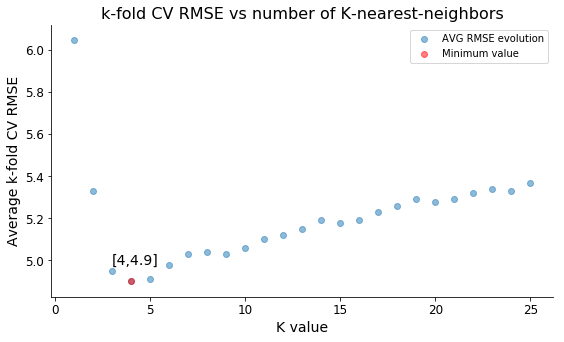

In [39]:
# Plot
# Scatter plot k-fold CV RMSE vs number of Nearest-Neighbors
# Figure size
plt.figure(figsize = (9, 5)) 

# Font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title(r'k-fold CV RMSE vs number of K-nearest-neighbors')
plt.xlabel(r'K value')
plt.ylabel(r'Average k-fold CV RMSE')

# Plot
ax.scatter([i for i in range(1, NIters + 1)], IterAVGRMSE, 
           alpha = 0.5, label = 'AVG RMSE evolution')
ax.scatter(KminRMSE, minRMSE, alpha = 0.5, label = 'Minimum value',
           color = "red")
ax.annotate("[" + str(KminRMSE) + "," + str(minRMSE) + "]",
            xy = (KminRMSE - 1, minRMSE + 0.08))

# Add legend
plt.legend()

In [40]:
# Confidence interval version
# Define the target variable name
dataTargetName = "MEDV"

# Normalize relevant features, extract the Target values and create the 
# normalized dataset, ready for using the K-fold CV function
bostonTarget = boston[dataTargetName]
bostonFeat = normalize(boston[["CRIM", "ZN", "RM", "AGE", "DIS", "TAX"]])
normboston = pd.concat([bostonFeat, bostonTarget], axis = 1)

# AVG RMSE and CI arrays (for iterations)
NIters = 25
IterAVGRMSE = np.repeat(0.0, NIters)
IterCI = np.repeat(0.0, NIters)

# Loop for k-fold CV
# Starting time
start = time.time()
for K in range(1, NIters + 1):
    print("-------------------- Outer Iteration with K =", K, "--------------------")
    
    # Call the function: k, data, name of the target value, L, and the model function
    k = 10
    L = 2
    verbose = False
    Result = KfoldCrossValCIw(k, normboston, dataTargetName, verbose, [L, K], knn)
    
    # Save the AVG RMSE from the current iteration
    IterAVGRMSE[K - 1] = Result[0]
    IterCI[K - 1] = Result[1]
    print("\nAverage K-fold CV RMSE:", Result[0])
    
# Total running time
print("\nGlobal running time: {:.2f} seconds".format(time.time() - start))

# Printout the RMSEs values for checking purposes
print("\nAVG RMSE array:", IterAVGRMSE)
print("\nCI Halfwidth array:", IterCI)

minRMSE = np.min(IterAVGRMSE)
KminRMSE = np.where(IterAVGRMSE==minRMSE)[0][0] + 1

-------------------- Outer Iteration with K = 1 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.16 seconds
RMSE testing set: 3.27587737088

------------ CV Iteration: 2 ------------
Time taken: 0.16 seconds
RMSE testing set: 4.53262681922

------------ CV Iteration: 3 ------------
Time taken: 0.16 seconds
RMSE testing set: 8.55167682216

------------ CV Iteration: 4 ------------
Time taken: 0.17 seconds
RMSE testing set: 5.32982727896

------------ CV Iteration: 5 ------------
Time taken: 0.16 seconds
RMSE testing set: 5.89113657931

------------ CV Iteration: 6 ------------
Time taken: 0.16 seconds
RMSE testing set: 4.32940244031

------------ CV Iteration: 7 ------------
Time taken: 0.16 seconds
RMSE testing set: 9.0825767269

------------ CV Iteration: 8 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.48406065971

------------ CV Iteration: 9 ------------
Time taken: 0.15 seconds
RMSE testing set: 5.72277904518

------------ CV Iteration: 10 -


------------ CV Iteration: 2 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.55094790231

------------ CV Iteration: 3 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.20361801449

------------ CV Iteration: 4 ------------
Time taken: 0.16 seconds
RMSE testing set: 6.28296331867

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.74818302452

------------ CV Iteration: 6 ------------
Time taken: 0.18 seconds
RMSE testing set: 3.47369712139

------------ CV Iteration: 7 ------------
Time taken: 0.14 seconds
RMSE testing set: 9.25090367207

------------ CV Iteration: 8 ------------
Time taken: 0.14 seconds
RMSE testing set: 3.39629255586

------------ CV Iteration: 9 ------------
Time taken: 0.16 seconds
RMSE testing set: 3.85144210005

------------ CV Iteration: 10 ------------
Time taken: 0.15 seconds
RMSE testing set: 8.24034586653

CI halfwidht: 1.54123616276
Standard deviation: 2.04393777959

Total running time: 1.55 seconds

A

------------ CV Iteration: 1 ------------
Time taken: 0.16 seconds
RMSE testing set: 3.89850102471

------------ CV Iteration: 2 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.8538753944

------------ CV Iteration: 3 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.09857534098

------------ CV Iteration: 4 ------------
Time taken: 0.17 seconds
RMSE testing set: 6.37761553846

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.60732636234

------------ CV Iteration: 6 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.59626882412

------------ CV Iteration: 7 ------------
Time taken: 0.16 seconds
RMSE testing set: 9.49291352068

------------ CV Iteration: 8 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.50319663546

------------ CV Iteration: 9 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.13908943287

------------ CV Iteration: 10 ------------
Time taken: 0.16 seconds
RMSE testing set: 8.20108198824



------------ CV Iteration: 2 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.1832572797

------------ CV Iteration: 3 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.24535181965

------------ CV Iteration: 4 ------------
Time taken: 0.15 seconds
RMSE testing set: 6.13125875335

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.06146379652

------------ CV Iteration: 6 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.8305335079

------------ CV Iteration: 7 ------------
Time taken: 0.14 seconds
RMSE testing set: 9.80775719722

------------ CV Iteration: 8 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.85392839186

------------ CV Iteration: 9 ------------
Time taken: 0.15 seconds
RMSE testing set: 4.36473811849

------------ CV Iteration: 10 ------------
Time taken: 0.15 seconds
RMSE testing set: 8.15552109801

CI halfwidht: 1.48341597016
Standard deviation: 1.96725850165

Total running time: 1.49 seconds

Aver

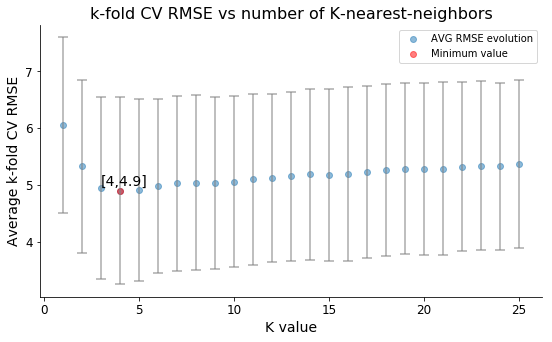

In [41]:
# Plot with error bars
# Scatter plot k-fold CV RMSE vs number of Nearest-Neighbors
# Figure size
plt.figure(figsize = (9, 5)) 

# Font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title(r'k-fold CV RMSE vs number of K-nearest-neighbors')
plt.xlabel(r'K value')
plt.ylabel(r'Average k-fold CV RMSE')

# Plot
ax.scatter([i for i in range(1, NIters + 1)], IterAVGRMSE, 
           alpha = 0.5, label = 'AVG RMSE evolution')
ax.scatter(KminRMSE, minRMSE, alpha = 0.5, label = 'Minimum value',
           color = "red")
ax.annotate("[" + str(KminRMSE) + "," + str(minRMSE) + "]",
            xy = (KminRMSE - 1, minRMSE + 0.08))

# Extra: Error Bar 
x = [i for i in range(1, NIters + 1)]
y = IterAVGRMSE
yerr = IterCI
ax.errorbar(x, y, yerr = yerr, ecolor = 'gray', lw = 2, 
            capsize = 5, fmt='none', capthick = 2, alpha = 0.5)

# Add legend
plt.legend()

## Observations
### What is the best choice of K?  Summarize what you see on the plot. What do you think is a reasonable choice of K for this model?

In order to determine the best choice of $K$, we have to define which criterion will indicate that the performance of the model is better. Clearly in our case, we will look for the minimum value of $RMSE$ as our main selection criterion, since it will indicate that the model average predictive error is the minimum among all the tested models (with different nmber of Nearest Neighbors $K$ values). 

Looking at the two generated plots (with and without error bars) we can clearly identify the minimum $RMSE$ value in the plot, associated with the value $K=4$, corresponding to an $RMSE=4.9$, leading us to conclude that the best choice of $K$ should be $4$. We note that this value is very similar to the ones obtained with $K=3$ ($4.95$) and $K=5$ ($4.91$) and further research must be done in order to obtain a formal conclusions: different number/mix of features and/or different values for $L$ could lead us to a different conclusion, since the difference is very small between those models.

Looking at the plots, we can see how the model average k-fold CV $RMSE$ tends to decrease when increasing the value of Nearest Neighbors $K$ up to the minimum in $K=4$. After reaching this global minimum, the trend is positive, indicating that adding extra Nearest Neighbors (increasing $K$) in our model will not benefit us in terms of the average $RMSE$ value, leading to higher preditive error.

Hence, a reasonable choice of $K$ for this model would be the optimal $K=4$, but also $K=3$ and $K=5$ would be valid. Further research is needed in order to determine the best value of $K$ in a more general setting.
 
As an extra analysis, we can take advantage of the plot including error bars since it will give us information regarding the variability of the sampled $RMSE$ values from the 10-fold Cross Validation algorithm. From the plot, we can see that the error bar size corresponding to $K=4$ is one of the largest ones accross all observations, indicating us that $K=4$ may not be the best choice since its variability is the highest accross the samples. Looking at the current values, we have that for $K=3$, the error bar size is $1.59$, for $K=4$ is equal to $1.65$ (the largest among all $K$ values), and for $K=5$ is $1.60$. Hence, it would be also reasonable to select $K=5$ as the best $K$ value.

However, further experiments should be performed in order to formally conclude which is the optimal $K$ value for the current dataset.


### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*

In [42]:
# Fast-Forward (FF) selection fixed K version
# Target variable name
dataTargetName = "MEDV"

# Extract all features from dataset
Features = boston.drop(dataTargetName, axis = 1).columns.tolist()

# Normalize relevant features, extract the Target values and create the 
# normalized dataset, ready for using the K-fold CV function
bostonTarget = boston[dataTargetName]
bostonFeat = normalize(boston[Features])
normboston = pd.concat([bostonFeat, bostonTarget], axis = 1)

# Maximum number of iterations for FF algorithm: total number of features
MaxOuterIters = len(Features)

# Auxiliary variables for recording Features selected for each iteration
IterFeatures = [None for i in range(0, MaxOuterIters)]
CurrentFeatures = []

# RMSE array for keeping each AVG RMSE value
OuterIterRMSE = np.repeat(1.0e10, MaxOuterIters)

# Set relevant parameters: K (NN), k (folds), and L (norm)
K = 4
k = 10
L = 2
verbose = False

# Starting time
startff = time.time()

# FF Algorithm loop
for n in range(1, MaxOuterIters + 1):
    print("\n----------------------------------",
          "Iteration", n, "----------------------------------")
    print("Current Features:", [f for f in IterFeatures if f != None])
    
    # Iteration initial status summary
    if (n == 1):
        print("Best RMSE value: None")
    else:
        print("Best RMSE value:", OuterIterRMSE[n-1])
    
    for i in Features:
        # Features to be included in the model
        # if iteration 1: test isolated features
        if (n == 1):
            TotestFeat = [i]

        # else, include the previously selected features plus the one being tested
        else:
            TotestFeat = [f for f in IterFeatures if f != None]
            if (IterFeatures[n] != None):
                TotestFeat.remove(IterFeatures[n])
            TotestFeat.append(i)
            
        # Print out the features to be included in the current model
        print("\nRunning model with features:", TotestFeat)

        # Include dataTargetName
        TotestFeat.append(dataTargetName)

        # Call the CV function with K-nn function
        Result = KfoldCrossVal(k, normboston[TotestFeat], dataTargetName, 
                               verbose, [L, K], knn)

        # Check values
        print("\nAverage K-fold CV RMSE:", Result)
        print("\nCurrent best feature:", IterFeatures[n])
        print("Current best AVG RMSE:", OuterIterRMSE[n])
        
        # If RMSE is smaller than the current one, update it and save the canditate 
        # feature to be added to the model
        if (Result < OuterIterRMSE[n]):
            OuterIterRMSE[n] = Result
            print("\nNew best AVG RMSE:", OuterIterRMSE[n])
            IterFeatures[n] = i
            print("New best feature added:", IterFeatures[n])
                  
    # Compare current RMSE with the previous iteration
    # If first iteration, save results, continue iterations
    if (n == 1):
        Features.remove(IterFeatures[n])
        CurrentFeatures.append(IterFeatures[n])
        print("\nFeature", IterFeatures[n], "has been added")
        print("Remaining features:",Features)
        print("Model k-fold CV AVG RMSE:", OuterIterRMSE[n])
        print("Next iteration...")
        
    # Else, check if the model has improved in comparison to previous iteration
    else:
        # If not, break the iterations, end of the FF alg.
        if (OuterIterRMSE[n] > OuterIterRMSE[n - 1]):
            print("\nModel has not improved with an extra feature, break")
            OuterIterRMSE[n] = 1.0e10
            break
            
        # Else, save results. Go to next iteration
        else:
            Features.remove(IterFeatures[n])
            CurrentFeatures.append(IterFeatures[n])
            print("\nFeature", IterFeatures[n], "has been added")
            print("Remaining features:",Features)
            print("Model k-fold CV AVG RMSE:", OuterIterRMSE[n])
            print("Next iteration...")

# Summary
print("Optimal Features:", CurrentFeatures)
print("Optimal k-fold CV AVG RMSE:", np.min(OuterIterRMSE))
print("\nTotal running time: {:.2f} seconds".format(time.time() - startff))


---------------------------------- Iteration 1 ----------------------------------
Current Features: []
Best RMSE value: None

Running model with features: ['CRIM']

------------ CV Iteration: 1 ------------
Time taken: 0.11 seconds
RMSE testing set: 8.21995047335

------------ CV Iteration: 2 ------------
Time taken: 0.06 seconds
RMSE testing set: 7.72226774449

------------ CV Iteration: 3 ------------
Time taken: 0.06 seconds
RMSE testing set: 7.83386158002

------------ CV Iteration: 4 ------------
Time taken: 0.06 seconds
RMSE testing set: 9.66280137394

------------ CV Iteration: 5 ------------
Time taken: 0.06 seconds
RMSE testing set: 7.1916115691

------------ CV Iteration: 6 ------------
Time taken: 0.06 seconds
RMSE testing set: 8.08476084019

------------ CV Iteration: 7 ------------
Time taken: 0.06 seconds
RMSE testing set: 11.6621712172

------------ CV Iteration: 8 ------------
Time taken: 0.06 seconds
RMSE testing set: 8.32129872676

------------ CV Iteration: 9 ------

Time taken: 0.06 seconds
RMSE testing set: 9.14322426718

Total running time: 0.68 seconds

Average K-fold CV RMSE: 9.21

Current best feature: RM
Current best AVG RMSE: 6.38

Running model with features: ['RAD']

------------ CV Iteration: 1 ------------
Time taken: 0.06 seconds
RMSE testing set: 7.5151546238

------------ CV Iteration: 2 ------------
Time taken: 0.06 seconds
RMSE testing set: 8.38494361411

------------ CV Iteration: 3 ------------
Time taken: 0.06 seconds
RMSE testing set: 7.87379542608

------------ CV Iteration: 4 ------------
Time taken: 0.06 seconds
RMSE testing set: 9.40175854431

------------ CV Iteration: 5 ------------
Time taken: 0.06 seconds
RMSE testing set: 6.74405875059

------------ CV Iteration: 6 ------------
Time taken: 0.06 seconds
RMSE testing set: 8.93105605485

------------ CV Iteration: 7 ------------
Time taken: 0.06 seconds
RMSE testing set: 12.287795266

------------ CV Iteration: 8 ------------
Time taken: 0.06 seconds
RMSE testing set: 8.5

------------ CV Iteration: 8 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.15968991316

------------ CV Iteration: 9 ------------
Time taken: 0.08 seconds
RMSE testing set: 3.57524474687

------------ CV Iteration: 10 ------------
Time taken: 0.08 seconds
RMSE testing set: 7.73966569045

Total running time: 0.86 seconds

Average K-fold CV RMSE: 5.09

Current best feature: CRIM
Current best AVG RMSE: 5.32

New best AVG RMSE: 5.09
New best feature added: INDUS

Running model with features: ['LSTAT', 'CHAS']

------------ CV Iteration: 1 ------------
Time taken: 0.08 seconds
RMSE testing set: 4.42176407659

------------ CV Iteration: 2 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.83725883324

------------ CV Iteration: 3 ------------
Time taken: 0.09 seconds
RMSE testing set: 4.32771364489

------------ CV Iteration: 4 ------------
Time taken: 0.08 seconds
RMSE testing set: 6.16914066695

------------ CV Iteration: 5 ------------
Time taken: 0.08 seconds
RMSE test


------------ CV Iteration: 9 ------------
Time taken: 0.08 seconds
RMSE testing set: 2.70187434941

------------ CV Iteration: 10 ------------
Time taken: 0.08 seconds
RMSE testing set: 6.84434985956

Total running time: 0.85 seconds

Average K-fold CV RMSE: 4.77

Current best feature: RM
Current best AVG RMSE: 4.55

Running model with features: ['LSTAT', 'B']

------------ CV Iteration: 1 ------------
Time taken: 0.08 seconds
RMSE testing set: 4.38497182901

------------ CV Iteration: 2 ------------
Time taken: 0.08 seconds
RMSE testing set: 6.00419073419

------------ CV Iteration: 3 ------------
Time taken: 0.08 seconds
RMSE testing set: 3.99417161158

------------ CV Iteration: 4 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.59934126028

------------ CV Iteration: 5 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.00881086432

------------ CV Iteration: 6 ------------
Time taken: 0.08 seconds
RMSE testing set: 5.48686488575

------------ CV Iteration: 7 ------

------------ CV Iteration: 9 ------------
Time taken: 0.10 seconds
RMSE testing set: 2.77899937028

------------ CV Iteration: 10 ------------
Time taken: 0.10 seconds
RMSE testing set: 6.37843730862

Total running time: 1.04 seconds

Average K-fold CV RMSE: 4.64

Current best feature: NOX
Current best AVG RMSE: 4.22

Running model with features: ['LSTAT', 'RM', 'DIS']

------------ CV Iteration: 1 ------------
Time taken: 0.10 seconds
RMSE testing set: 3.00215812898

------------ CV Iteration: 2 ------------
Time taken: 0.13 seconds
RMSE testing set: 3.16626867984

------------ CV Iteration: 3 ------------
Time taken: 0.11 seconds
RMSE testing set: 3.45551385186

------------ CV Iteration: 4 ------------
Time taken: 0.10 seconds
RMSE testing set: 5.73532868265

------------ CV Iteration: 5 ------------
Time taken: 0.10 seconds
RMSE testing set: 5.48144709497

------------ CV Iteration: 6 ------------
Time taken: 0.10 seconds
RMSE testing set: 4.03166085078

------------ CV Iteration: 


------------ CV Iteration: 7 ------------
Time taken: 0.11 seconds
RMSE testing set: 7.06585628215

------------ CV Iteration: 8 ------------
Time taken: 0.11 seconds
RMSE testing set: 3.36399873662

------------ CV Iteration: 9 ------------
Time taken: 0.11 seconds
RMSE testing set: 2.90120664552

------------ CV Iteration: 10 ------------
Time taken: 0.11 seconds
RMSE testing set: 6.17751264669

Total running time: 1.17 seconds

Average K-fold CV RMSE: 4.27

Current best feature: CRIM
Current best AVG RMSE: 4.04

Running model with features: ['LSTAT', 'RM', 'NOX', 'INDUS']

------------ CV Iteration: 1 ------------
Time taken: 0.16 seconds
RMSE testing set: 2.54658075258

------------ CV Iteration: 2 ------------
Time taken: 0.12 seconds
RMSE testing set: 3.26387685994

------------ CV Iteration: 3 ------------
Time taken: 0.16 seconds
RMSE testing set: 3.23788465805

------------ CV Iteration: 4 ------------
Time taken: 0.11 seconds
RMSE testing set: 4.56951750145

------------ CV 

RMSE testing set: 3.11795283832

------------ CV Iteration: 7 ------------
Time taken: 0.11 seconds
RMSE testing set: 6.80068838427

------------ CV Iteration: 8 ------------
Time taken: 0.11 seconds
RMSE testing set: 3.11283632721

------------ CV Iteration: 9 ------------
Time taken: 0.11 seconds
RMSE testing set: 2.66299408561

------------ CV Iteration: 10 ------------
Time taken: 0.11 seconds
RMSE testing set: 6.43667033489

Total running time: 1.17 seconds

Average K-fold CV RMSE: 4.02

Current best feature: DIS
Current best AVG RMSE: 3.94

Running model with features: ['LSTAT', 'RM', 'NOX', 'B']

------------ CV Iteration: 1 ------------
Time taken: 0.12 seconds
RMSE testing set: 2.55979950961

------------ CV Iteration: 2 ------------
Time taken: 0.12 seconds
RMSE testing set: 2.64361977035

------------ CV Iteration: 3 ------------
Time taken: 0.12 seconds
RMSE testing set: 3.30676668097

------------ CV Iteration: 4 ------------
Time taken: 0.12 seconds
RMSE testing set: 4.44

Time taken: 0.13 seconds
RMSE testing set: 3.23720331368

------------ CV Iteration: 4 ------------
Time taken: 0.13 seconds
RMSE testing set: 4.59129344414

------------ CV Iteration: 5 ------------
Time taken: 0.13 seconds
RMSE testing set: 4.28243677197

------------ CV Iteration: 6 ------------
Time taken: 0.13 seconds
RMSE testing set: 4.2138936282

------------ CV Iteration: 7 ------------
Time taken: 0.13 seconds
RMSE testing set: 6.13006627207

------------ CV Iteration: 8 ------------
Time taken: 0.13 seconds
RMSE testing set: 2.85723423961

------------ CV Iteration: 9 ------------
Time taken: 0.13 seconds
RMSE testing set: 2.58152329062

------------ CV Iteration: 10 ------------
Time taken: 0.13 seconds
RMSE testing set: 7.13496758927

Total running time: 1.33 seconds

Average K-fold CV RMSE: 4.08

Current best feature: INDUS
Current best AVG RMSE: 3.8

Running model with features: ['LSTAT', 'RM', 'NOX', 'DIS', 'TAX']

------------ CV Iteration: 1 ------------
Time taken: 0

------------ CV Iteration: 10 ------------
Time taken: 0.15 seconds
RMSE testing set: 5.85451108121

Total running time: 1.67 seconds

Average K-fold CV RMSE: 3.73

Current best feature: CRIM
Current best AVG RMSE: 3.79

New best AVG RMSE: 3.73
New best feature added: INDUS

Running model with features: ['LSTAT', 'RM', 'NOX', 'DIS', 'B', 'CHAS']

------------ CV Iteration: 1 ------------
Time taken: 0.17 seconds
RMSE testing set: 3.01137345709

------------ CV Iteration: 2 ------------
Time taken: 0.16 seconds
RMSE testing set: 2.60209662825

------------ CV Iteration: 3 ------------
Time taken: 0.15 seconds
RMSE testing set: 3.16314755441

------------ CV Iteration: 4 ------------
Time taken: 0.16 seconds
RMSE testing set: 4.87568999642

------------ CV Iteration: 5 ------------
Time taken: 0.15 seconds
RMSE testing set: 5.08982910264

------------ CV Iteration: 6 ------------
Time taken: 0.15 seconds
RMSE testing set: 2.62734255885

------------ CV Iteration: 7 ------------
Time take

------------ CV Iteration: 4 ------------
Time taken: 0.16 seconds
RMSE testing set: 4.28363278117

------------ CV Iteration: 5 ------------
Time taken: 0.16 seconds
RMSE testing set: 4.25992497402

------------ CV Iteration: 6 ------------
Time taken: 0.17 seconds
RMSE testing set: 2.8509673281

------------ CV Iteration: 7 ------------
Time taken: 0.18 seconds
RMSE testing set: 5.84430705901

------------ CV Iteration: 8 ------------
Time taken: 0.16 seconds
RMSE testing set: 2.92128182482

------------ CV Iteration: 9 ------------
Time taken: 0.16 seconds
RMSE testing set: 2.66702080982

------------ CV Iteration: 10 ------------
Time taken: 0.18 seconds
RMSE testing set: 6.06121378108

Total running time: 1.71 seconds

Average K-fold CV RMSE: 3.76

Current best feature: CRIM
Current best AVG RMSE: 3.74

Running model with features: ['LSTAT', 'RM', 'NOX', 'DIS', 'B', 'TAX', 'INDUS']

------------ CV Iteration: 1 ------------
Time taken: 0.17 seconds
RMSE testing set: 2.28419280375


Average K-fold CV RMSE: 3.57

Current best feature: None
Current best AVG RMSE: 10000000000.0

New best AVG RMSE: 3.57
New best feature added: CRIM

Running model with features: ['LSTAT', 'RM', 'NOX', 'DIS', 'B', 'TAX', 'INDUS', 'ZN']

------------ CV Iteration: 1 ------------
Time taken: 0.18 seconds
RMSE testing set: 2.31505092478

------------ CV Iteration: 2 ------------
Time taken: 0.19 seconds
RMSE testing set: 3.09356938966

------------ CV Iteration: 3 ------------
Time taken: 0.19 seconds
RMSE testing set: 2.9239125681

------------ CV Iteration: 4 ------------
Time taken: 0.18 seconds
RMSE testing set: 4.2733284199

------------ CV Iteration: 5 ------------
Time taken: 0.20 seconds
RMSE testing set: 4.18476022458

------------ CV Iteration: 6 ------------
Time taken: 0.18 seconds
RMSE testing set: 2.80668189065

------------ CV Iteration: 7 ------------
Time taken: 0.18 seconds
RMSE testing set: 5.54097125963

------------ CV Iteration: 8 ------------
Time taken: 0.18 seconds

Time taken: 0.20 seconds
RMSE testing set: 4.14611500176

------------ CV Iteration: 5 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.3736126415

------------ CV Iteration: 6 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.97456126275

------------ CV Iteration: 7 ------------
Time taken: 0.19 seconds
RMSE testing set: 5.53915832957

------------ CV Iteration: 8 ------------
Time taken: 0.19 seconds
RMSE testing set: 2.63188620575

------------ CV Iteration: 9 ------------
Time taken: 0.23 seconds
RMSE testing set: 2.58495406149

------------ CV Iteration: 10 ------------
Time taken: 0.19 seconds
RMSE testing set: 5.9730425664

Total running time: 2.04 seconds

Average K-fold CV RMSE: 3.58

Current best feature: CRIM
Current best AVG RMSE: 3.53

Running model with features: ['LSTAT', 'RM', 'NOX', 'DIS', 'B', 'TAX', 'INDUS', 'RAD', 'CHAS']

------------ CV Iteration: 1 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.88143835781

------------ CV Iteration: 

Time taken: 0.21 seconds
RMSE testing set: 2.77041061938

------------ CV Iteration: 10 ------------
Time taken: 0.21 seconds
RMSE testing set: 5.88725317954

Total running time: 2.16 seconds

Average K-fold CV RMSE: 4.1

Current best feature: CRIM
Current best AVG RMSE: 3.42

Running model with features: ['LSTAT', 'RM', 'NOX', 'DIS', 'B', 'TAX', 'INDUS', 'RAD', 'AGE', 'PTRATIO']

------------ CV Iteration: 1 ------------
Time taken: 0.21 seconds
RMSE testing set: 2.29394450076

------------ CV Iteration: 2 ------------
Time taken: 0.22 seconds
RMSE testing set: 3.0750577868

------------ CV Iteration: 3 ------------
Time taken: 0.21 seconds
RMSE testing set: 2.86172125292

------------ CV Iteration: 4 ------------
Time taken: 0.21 seconds
RMSE testing set: 4.10676599781

------------ CV Iteration: 5 ------------
Time taken: 0.22 seconds
RMSE testing set: 3.63072401357

------------ CV Iteration: 6 ------------
Time taken: 0.22 seconds
RMSE testing set: 3.05845220691

------------ CV I

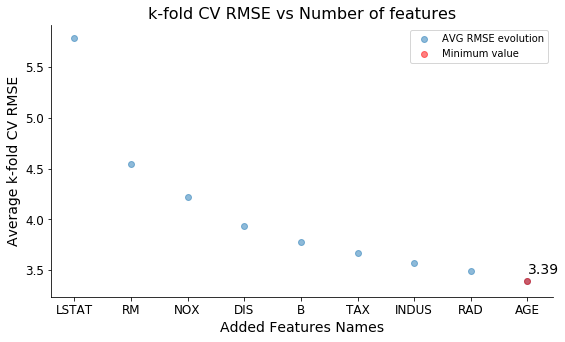

In [43]:
# Plot
# Scatter plot k-fold CV RMSE vs FForward features selection
# Figure size
plt.figure(figsize = (9, 5)) 

# Font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title(r'k-fold CV RMSE vs Number of features')
plt.xlabel(r'Added Features Names')
plt.ylabel(r'Average k-fold CV RMSE')

# Axis values
x = [i for i in range(1, len(CurrentFeatures) + 1)]
y = [i for i in OuterIterRMSE if i < 1e5]

# Plot
ax.scatter(x, y, alpha = 0.5, label = 'AVG RMSE evolution')
ax.scatter(len(CurrentFeatures), np.min(OuterIterRMSE), alpha = 0.5,
           label = 'Minimum value', color = "red")

# Set x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(CurrentFeatures, rotation = 'horizontal')

# Add label to the minimum value
ax.annotate(str(np.min(OuterIterRMSE)),xy=(len(CurrentFeatures), 
                                           np.min(OuterIterRMSE) + 0.08))

# Add legend
plt.legend()

In [44]:
# Check optimal K for the features selected by FF algorithm
# Define the target variable name
dataTargetName = "MEDV"

# Normalize relevant features, extract the Target values and create the 
# normalized dataset, ready for using the K-fold CV function
bostonTarget = boston[dataTargetName]
bostonFeat = normalize(boston[CurrentFeatures])
normboston = pd.concat([bostonFeat, bostonTarget], axis = 1)

# AVG RMSE array (for iterations)
NIters = 25
IterAVGRMSE = np.repeat(0.0, NIters)

# Loop for k-fold CV
# Starting time
start = time.time()
for K in range(1, NIters + 1):
    print("-------------------- Outer Iteration with K =", K, "--------------------")
    
    # Call the function: k, data, name of the target value, L, and the model function
    k = 10
    L = 2
    verbose = False
    Result = KfoldCrossVal(k, normboston, dataTargetName, verbose, [L, K], knn)
    
    # Save the AVG RMSE from the current iteration
    IterAVGRMSE[K - 1] = Result
    print("\nAverage K-fold CV RMSE:", Result)
    
# Total running time
print("\nGlobal running time: {:.2f} seconds".format(time.time() - start))

# Printout the RMSEs values for checking purposes
print("\nAVG RMSE array:", IterAVGRMSE)
minRMSE = np.min(IterAVGRMSE)
KminRMSE = np.where(IterAVGRMSE==minRMSE)[0][0] + 1

-------------------- Outer Iteration with K = 1 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.6678918754

------------ CV Iteration: 2 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.47382368297

------------ CV Iteration: 3 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.99950977388

------------ CV Iteration: 4 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.11397860383

------------ CV Iteration: 5 ------------
Time taken: 0.20 seconds
RMSE testing set: 4.86441661657

------------ CV Iteration: 6 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.43632638916

------------ CV Iteration: 7 ------------
Time taken: 0.19 seconds
RMSE testing set: 3.64581952378

------------ CV Iteration: 8 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.9927913392

------------ CV Iteration: 9 ------------
Time taken: 0.19 seconds
RMSE testing set: 2.84903492432

------------ CV Iteration: 10 --

Time taken: 0.22 seconds
RMSE testing set: 4.28570962447

------------ CV Iteration: 5 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.74148584108

------------ CV Iteration: 6 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.46410754238

------------ CV Iteration: 7 ------------
Time taken: 0.19 seconds
RMSE testing set: 5.77141095184

------------ CV Iteration: 8 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.34443053822

------------ CV Iteration: 9 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.35458595086

------------ CV Iteration: 10 ------------
Time taken: 0.19 seconds
RMSE testing set: 6.58032080335

Total running time: 2.01 seconds

Average K-fold CV RMSE: 3.75
-------------------- Outer Iteration with K = 9 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.018690667

------------ CV Iteration: 2 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.37420835368

----------

RMSE testing set: 3.88453549347

------------ CV Iteration: 9 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.80140885191

------------ CV Iteration: 10 ------------
Time taken: 0.20 seconds
RMSE testing set: 6.72087943981

Total running time: 2.03 seconds

Average K-fold CV RMSE: 4.22
-------------------- Outer Iteration with K = 16 --------------------

------------ CV Iteration: 1 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.69033457022

------------ CV Iteration: 2 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.51660604504

------------ CV Iteration: 3 ------------
Time taken: 0.22 seconds
RMSE testing set: 3.11261971677

------------ CV Iteration: 4 ------------
Time taken: 0.20 seconds
RMSE testing set: 5.00060229216

------------ CV Iteration: 5 ------------
Time taken: 0.19 seconds
RMSE testing set: 3.56665875681

------------ CV Iteration: 6 ------------
Time taken: 0.20 seconds
RMSE testing set: 2.82035151343

------------ CV Iteration: 7 ---

Time taken: 0.20 seconds
RMSE testing set: 3.53545836927

------------ CV Iteration: 3 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.29405090135

------------ CV Iteration: 4 ------------
Time taken: 0.20 seconds
RMSE testing set: 5.4398724674

------------ CV Iteration: 5 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.48674120724

------------ CV Iteration: 6 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.14526490975

------------ CV Iteration: 7 ------------
Time taken: 0.20 seconds
RMSE testing set: 7.87462390856

------------ CV Iteration: 8 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.90451616757

------------ CV Iteration: 9 ------------
Time taken: 0.20 seconds
RMSE testing set: 3.0663004562

------------ CV Iteration: 10 ------------
Time taken: 0.20 seconds
RMSE testing set: 6.73284438947

Total running time: 2.03 seconds

Average K-fold CV RMSE: 4.45
-------------------- Outer Iteration with K = 24 --------------------

---------

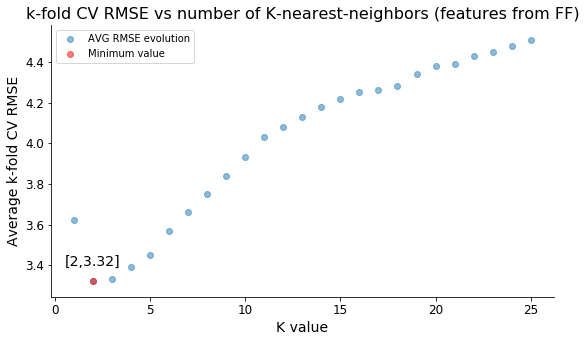

In [45]:
# Plot
# Scatter plot k-fold CV RMSE vs number of Nearest-Neighbors
# Figure size
plt.figure(figsize = (9, 5)) 

# Font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# axes
ax = plt.subplot(111)                    
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Title and labels
plt.title(r'k-fold CV RMSE vs number of K-nearest-neighbors (features from FF)')
plt.xlabel(r'K value')
plt.ylabel(r'Average k-fold CV RMSE')

# Plot
ax.scatter([i for i in range(1, NIters + 1)], IterAVGRMSE, 
           alpha = 0.5, label = 'AVG RMSE evolution')
ax.scatter(KminRMSE, minRMSE, alpha = 0.5, label = 'Minimum value',
           color = "red")
ax.annotate("[" + str(KminRMSE) + "," + str(minRMSE) + "]",
            xy = (KminRMSE - 1.5, minRMSE + 0.08))

"""
Extra: Error Bar 
x = [i for i in range(1, NIters + 1)]
y = IterAVGRMSE
yerr = 0.2
ax.errorbar(x, y, yerr = yerr, ecolor = 'gray', lw = 2, 
            capsize = 5, fmt='none', capthick = 2, alpha = 0.5)
"""

# Add legend
plt.legend()

### Observations

Based on the implemented Fast-Forward algorithm (breaks if no improvement occurs between iterations), we have the following results:
 -  Optimal Variables (9): $LSTAT$, $RM$, $NOX$, $DIS$, $B$, $TAX$, $INDUS$, $RAD$, $AGE$
 - $RMSE= 3.39$
 - Estimated running time: $109.89s]$
 
After solving the model using our Fast-Forward algorithm implementation with $K$ fixed to $4$ (best $K$ obtained in the previous optimization problem), we perform an optimization of the $K$ value using the optimal features found. The results are the following:  
 - Optimal $K$ value with the optimal features: $K=2$ 
 - $RMSE = 3.32$
 - Estimated running time: $50.41$
 
 Hence, this model (last one) reached the best performance in terms of $RMSE$ among all the models previously developed. However, we have to take into account the trade-off between running time and solution quality/accuracy since we needed about $50[s]$ extra seconds for getting the new optimal $K$ value associated with the optimal features found by our Fast-Forward algorithm implementation.
 
 Further research must be conducted in this data set in order to find the optimal combination of features, tuning parameters, and trade-off between running time and solution quality for determining the best/optimal configuration.